# 1. Постановка задачи

## 1.1 Цель
Предсказать стоимости индекса S&P 500 (или других биржевых индексов, стоимостей акций) на основании исторических данных.

## 1.2 Описание и актуальность задачи
Цены на акции все время движутся вверх и вниз, и способность предсказывать их движение имеет огромный потенциал, для заработка на данном движении. С появлением больших вычислительных мощностей многие инвесторы пытаются применять различные модели машинного обучения для предсказания будущей стоимости биржевых инструментов и осуществления высокочастотной торговли на их движениях. Для торговли на биржевых рынках на основании моделей машинного обучения создаются квантоментальные (квантовые) фонды, по разным оценкам объем такой торговли на 2017 год составляет от 1 до 1,5 трлн. долларов (1,5 трлн. по оценкам инвестиционного банка Morgan Stanley).
Для построения таких моделей используются различные источники и модели данных, в первую очередь используются исторические данные временных рядов для их анализа с помощью различных моделей машинного обучения и нейронных сетей, дополнительно используется анализ новостей для определения событий влияющих на котировки (NLP и тематическое моделирование), анализ спутниковых изображений для обнаружения техногенных катастроф или анализа положения нефтянных танкеров и др. Область предсказания котировок в рамках различных инвест-фондов и отдельных инвесторов часто пытается применить наиболее продвинутые технологии и методы для предсказания котировок и получения преимущества над другими инвесторами. 

В рамках данной дипломной работы будут использоваться только методы предсказания временных рядов для задачи прогнозирования будущей стоимости данной акции, на основании исторической дневной цены закрытия для индекса S&P 500. Индекс S&P 500 или Standard and Poor's 500 - это индекс, состоящий из 500 акций из различных секторов экономики США, и индикатор акций США. Другими такими индексами являются Dow 30, NIFTY 50, Nikkei 225 и т. д.
В качестве первоначального решения используется решение с Kaggle, на основании этого же решения в качестве источника данных используются данные полученные из Yahoo Financial. Период загрузки данных может варьироваться в рамках дипломной работы.

[Описание от Kaggle](https://www.kaggle.com/arashnic/time-series-forecasting-with-yahoo-stock-price)

## 1.3 Метрики качества

#### MAE - Cредняя абсолютная ошибка - https://en.wikipedia.org/wiki/Mean_absolute_error
Измеряется как сумма разниц между фактическим и прогнозным значением взятые по модулю разделенная на количество ошибок.
$$ MAE = \frac{1}{N} \sum_{t=1}^{N} |Yt-Ytp| $$
Где N - количество ошибок, Yt - фактическое значение, Ytp - прогнозное значение.

При использовании данной ошибки должно быть четкое понимание, какие данные она отражает, например ошибка в 10 000 для значений ряда состоящего из значений больше миллиона, составит 1 и менее процентов, а для ряда со значениям от 50 000 до 100 000, составит 10-20%. 

#### MAPE - Средняя абсолютная ошибка в процентах - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
Измеряется как сумма разниц между фактическим и прогнозным значением разделенная на фактическое значение умноженное на 100% и деленное на количество ошибок.
$$ MAPE = \frac{1}{N} \sum_{t=1}^{N} \frac{|Yt-Ytp|}{Yt}100\% $$
Показывает относительное отклонение прогнозных значений от фактических.

#### MSE - Среднеквадратичная ошибка - https://en.wikipedia.org/wiki/Mean_squared_error
Измеряется как сумма разниц между фактическим и прогнозным значением возведенных в квадрат разделенная на количество ошибок. 
$$ MSE = \frac{1}{N} \sum_{t=1}^{N} (Yt-Ytp)^2 $$

#### RMSE - Квадратный корень из среднеквадратичной ошибки - https://en.wikipedia.org/wiki/Root-mean-square_deviation
$$ RMSE = \sqrt{MSE} $$

#### ME - Средняя ошибка - https://en.wikipedia.org/wiki/Mean
$$ ME = \frac{1}{N} \sum_{t=1}^{N} (Yt-Ytp) $$

#### SD - Стандартное отклонение - https://en.wikipedia.org/wiki/Standard_deviation
$$ SD = \sqrt{\frac{1}{N} \sum_{t=1}^{N} (Ytp-ME)^2} $$

В рамках данной дипломной работы будем измерять все вышеперечисленные виды ошибок.

# 2. Анализ

## 2.1 Существующие решения
 
В сформированной задаче на Kaggle (https://www.kaggle.com/arashnic/time-series-forecasting-with-yahoo-stock-price) приведено базовое решение данной задачи, с помощью простой нейросети на базе LSTM. 

Данное решение приведено ниже, результат с данными и параметрами по умолчанию RMSE = 0,02-0,04 для нормализованных данных

In [1]:
import numpy as np 
import pandas as pd
import pandas_datareader as pdr
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import math
import time

import keras
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_raw_data(index_name,retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except:
                print("Data pull failed. {} retry attempts remaining".\
                      format(retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None

,High,Low,Open,Close,Volume,Adj Close
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3.620410e+09,2275.320068
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3.462130e+09,2270.439941
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3.081270e+09,2274.639893
2017-01-14,2278.679932,2271.510010,2272.739990,2274.639893,3.081270e+09,2274.639893
2017-01-15,2278.679932,2271.510010,2272.739990,2274.639893,3.081270e+09,2274.639893


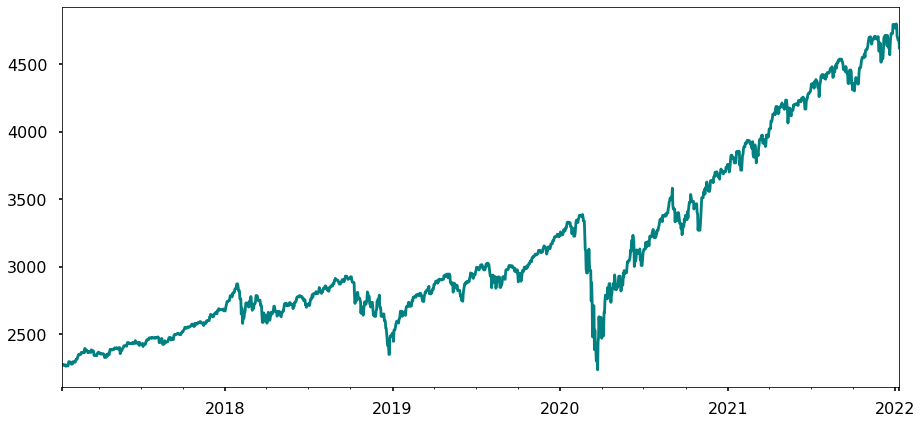

In [4]:
sp_df = get_raw_data('^GSPC')
sp_close_series = sp_df.Close
plt.style.use('seaborn-poster')
sp_close_series.plot(figsize=(15, 7), color = 'teal')
sp_df.head()

In [5]:
sp_df.index.min(), sp_df.index.max()

(Timestamp('2017-01-11 00:00:00', freq='D'),
 Timestamp('2022-01-10 00:00:00', freq='D'))

In [6]:
WINDOW = 6
PRED_LENGTH = int(WINDOW/2)
def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):
    # smoothen out series
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
    
    # create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])
           
    
    # normalize data as a variation of 0th index
    if normalize:
        normalised_data = []
        for window in result:
            normalised_window = [((float(p) / float(window[0])) - 1) \
                                   for p in window]
            normalised_data.append(normalised_window)
        result = normalised_data
    
    # identify train-test splits
    result = np.array(result) 
    row = round(train_size * result.shape[0])
    
    # split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # scale data in 0-1 range
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
      
    # split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Transforms for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], 
                                   x_train.shape[1], 
                                   1))
    x_test = np.reshape(x_test, (x_test.shape[0], 
                                 x_test.shape[1], 
                                 1)) 
    
    return x_train,y_train,x_test,y_test,scaler

x_train,y_train,x_test,y_test,scaler = get_reg_train_test(sp_close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(1637, 6, 1)
y_train shape=(1637,)
x_test shape=(182, 6, 1)
y_test shape=(182,)


In [7]:
def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

lstm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)

> Compilation Time :  0.004986286163330078
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params:

In [8]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
lstm_model.fit(x_train, y_train, 
               epochs=20, batch_size=16,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Epoch 1/20
98/98 [==============================] - 8s 16ms/step - loss: 3.6731e-04 - val_loss: 1.1557e-04
Epoch 2/20
98/98 [==============================] - 1s 8ms/step - loss: 2.2868e-04 - val_loss: 1.9341e-04
Epoch 3/20
98/98 [==============================] - 1s 8ms/step - loss: 1.8196e-04 - val_loss: 6.5046e-05
Epoch 4/20
98/98 [==============================] - 1s 8ms/step - loss: 1.5075e-04 - val_loss: 5.0208e-05
Epoch 5/20
98/98 [==============================] - 1s 7ms/step - loss: 1.4995e-04 - val_loss: 4.4769e-05
Epoch 6/20
98/98 [==============================] - 1s 7ms/step - loss: 1.4164e-04 - val_loss: 3.3699e-05
Epoch 7/20
98/98 [==============================] - 1s 7ms/step - loss: 1.3291e-04 - val_loss: 4.4318e-05
Epoch 8/20
98/98 [==============================] - 1s 7ms/step - loss: 1.3459e-04 - val_loss: 5.2666e-05
Model Fit Complete


In [9]:
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    
    # loop for every sequence in the dataset
    for window in tqdm(range(int(len(data)/prediction_len))):
        _seq = data[window*prediction_len]
        predicted = []
        # loop till required prediction length is achieved
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list


train_pred_seqs = predict_reg_multiple(lstm_model,
                                             x_train,
                                             window_size=WINDOW,
                                             prediction_len=PRED_LENGTH)

train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]

train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:], 
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))

100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [01:08<00:00,  7.95it/s]

Train Score: 0.02 RMSE


In [10]:
test_pred_seqs = predict_reg_multiple(lstm_model,
                                      x_test,
                                      window_size=WINDOW,
                                      prediction_len=PRED_LENGTH)
test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]

test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:], 
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.12it/s]

Test Score: 0.02 RMSE


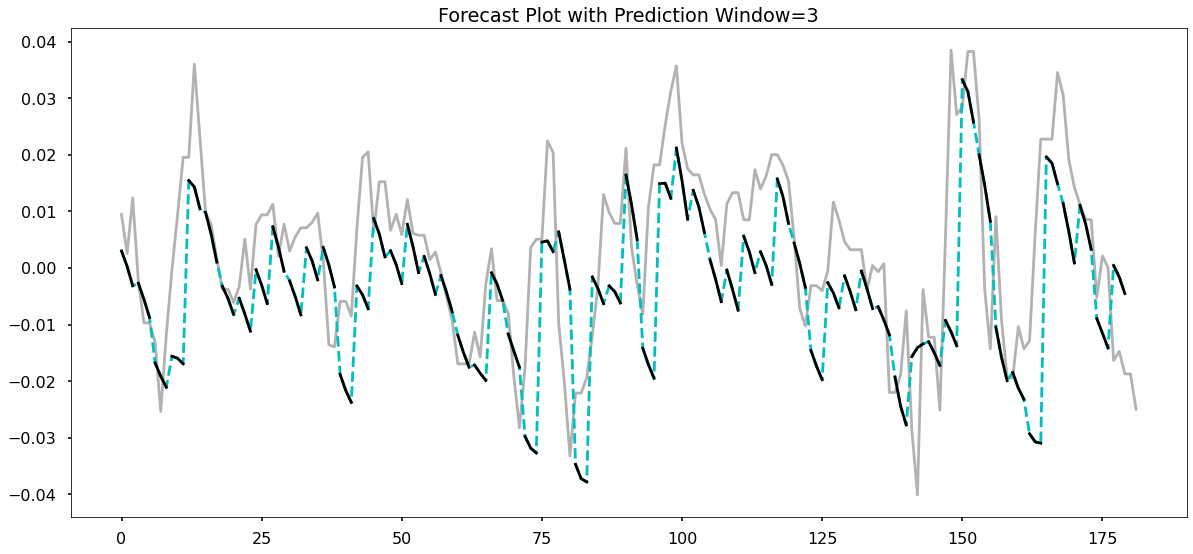

In [11]:
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white', figsize=(20, 9))
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot flattened data
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='c',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()

plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)

В других решениях данной задачи используется SARIMA (RMSE=515.46), усложненная LSTM , RNN (72.35)

## 2.2 Загрузка и анализ данных.

### 2.2.1 Имортируем библиотеки

In [1]:
import numpy as np 
import pandas as pd
import pandas_datareader as pdr
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import math
import time
import warnings

import keras
from itertools import product
from tqdm import tqdm_notebook, tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf as plt_acf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
warnings.simplefilter("ignore")

In [3]:
from neuralprophet import NeuralProphet

### 2.2.2 Вспомогательные функции для обработки данных

In [4]:
#код загрузки практически полностью совпадает с кодом выше, изменено только название функции и добавлена возможность указать период начала загрузки данных.
def get_raw_data_SP(index_name, start_date, end_date, retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name, start=start_date, end=end_date)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except:
                print("Data pull failed. {} retry attempts remaining".\
                      format(retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None


def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_reg_results_new(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white', figsize=(20, 9))
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot predicted data
    plt.plot(predicted_data, 
             label='Prediction_full',
             c='c',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction")
    plt.show()

def measure_error (prediction_data, test_data):
    test_mae = mean_absolute_error(test_data, prediction_data)
    test_mape = mean_absolute_percentage_error(test_data, prediction_data)
    test_mse = mean_squared_error(test_data, prediction_data)
    test_rmse = math.sqrt(test_mse)
    test_me = np.average((test_data - prediction_data).dropna(), axis=0)
    test_sd = math.sqrt(np.average(((prediction_data - test_me)**2).dropna(), axis=0))
    print (f'MAE: {test_mae:.3f}, MAPE: {test_mape:.3%}, MSE: {test_mse:.3f}, RMSE: {test_rmse:.3f}, ME: {test_me:.3f}, SD: {test_sd:.3f}')

In [5]:
WINDOW = 6
PRED_LENGTH = int(WINDOW/2)

In [6]:
def train_model_SARIMAX (endog, window=6, pred_len=1): #for Sarimax
    rolling_predictions = endog[:window]
    for i in range(0, (len(endog)-window-pred_len), 3):
        model = SARIMAX(endog=endog[i:i+window], order=(best_param[0], d, best_param[1]), seasonal_order=(best_param[2], D, best_param[3], s))
        model_fit = model.fit()
        pred = model_fit.forecast(pred_len)
        rolling_predictions=rolling_predictions.append(pred)
        
    return rolling_predictions

In [7]:
def train_model_prophet (data, prediction_period=60, window=6, pred_len=3): #for prophet
    rolling_predictions = pd.DataFrame(columns=['ds', 'yhat']).set_index('ds')
    for i in tqdm(range(0, prediction_period, pred_len)):
        train_data = data[:len(data)-prediction_period+i]
        m_new_window = prophet.Prophet(n_changepoints=100, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)
        m_new_window.add_country_holidays(country_name='US')
        m_new_window.fit(train_data)
        future = m_new_window.make_future_dataframe(periods=pred_len)
        predicted_data = m_new_window.predict(future)
        pred = predicted_data[['ds', 'yhat']][-pred_len:].set_index('ds')
        rolling_predictions=rolling_predictions.append(pred)
            
    return rolling_predictions

### 2.2.3 Загружаем данные

В качестве источника данных для анализа используются данные с сервиса Yahoo Finance загружаемые с помощью библиотеки pandas_datareader

In [8]:
start_date='01.01.2010'
end_date='25.12.2021'

sp_df = get_raw_data_SP('^GSPC', start_date, end_date)
sp_close_series = sp_df.Close

### 2.2.4 Данные и их визуализация

In [22]:
sp_df.head()

,High,Low,Open,Close,Volume,Adj Close
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3.991400e+09,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2.491020e+09,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4.972660e+09,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5.270680e+09,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4.389590e+09,1144.979980


Индекс - дата торговой сессии, High - максимальное значение индекса за торговую сессию, Low - минимальное значение за торговую сессию, Open - стоимость при открытии сессии, Close - стоимость при закрытии сессии, Volume - объем сделок в течении торговой сессии, adjusted closing price - это расчетная корректировка цены закрытия.

Используем данные за период с 01.01.2010 по 24.12.2021 гг, для фиксированного результата.

<AxesSubplot:title={'center':'S&P 500 Close c 01.01.2010 по 25.12.2021'}>

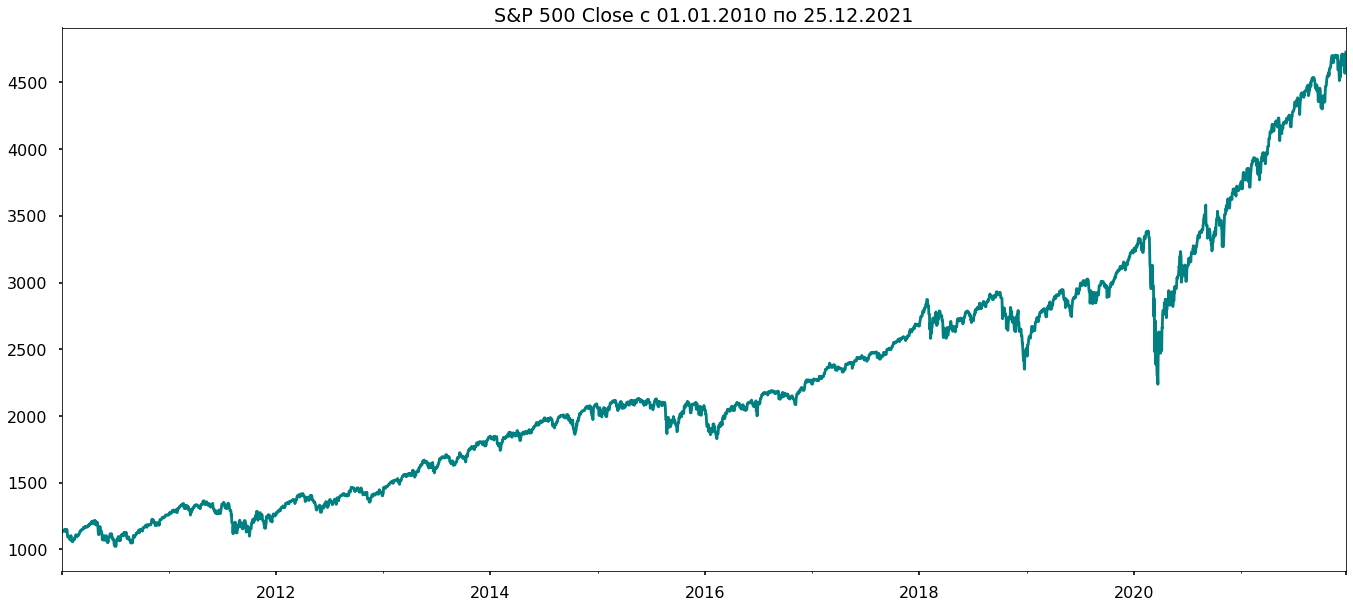

In [23]:
sp_close_series.plot(figsize=(23, 10), color = 'teal', title = f'S&P 500 Close c {start_date} по {end_date}')

### 2.2.5 Ключевая информация по загруженным данным

In [24]:
sp_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4372.000000,4372.000000,4372.000000,4372.000000,4.372000e+03,4372.000000
mean,2265.864551,2242.448302,2254.657634,2255.250668,3.830256e+09,2255.250668
std,887.100965,879.330157,883.213387,883.677900,1.024875e+09,883.677900
min,1032.949951,1010.909973,1027.650024,1022.580017,1.025000e+09,1022.580017
25%,1467.722443,1458.712494,1461.000000,1461.347504,3.223395e+09,1461.347504
50%,2094.694946,2078.609985,2087.379883,2086.415039,3.638590e+09,2086.415039
75%,2806.157532,2777.149963,2794.100098,2792.669922,4.223740e+09,2792.669922
max,4743.830078,4703.959961,4719.129883,4725.790039,1.061781e+10,4725.790039


Пропущенные данные отсутствуют. Все данные являются числовыми переменными.

### 2.2.5.1 Построим тепловую карту корреляции

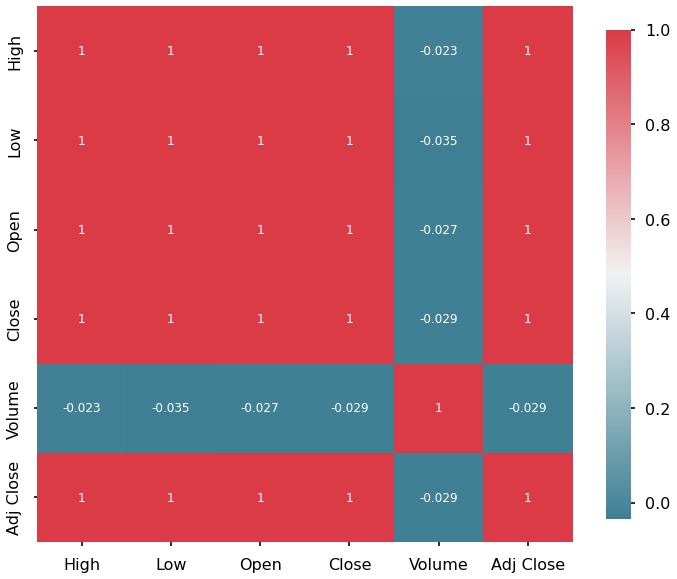

In [25]:
plot_correlation_map( sp_df )

Все данные по стоимости имеют 100% корреляцию. Поэтому в дальнейшем будем работать только со стоимостью закрытия, как это предложено в задании на Kaggle.

### 2.2.5.2 Проверим ряд на стационарность

Построим гистограмму распределения

<AxesSubplot:>

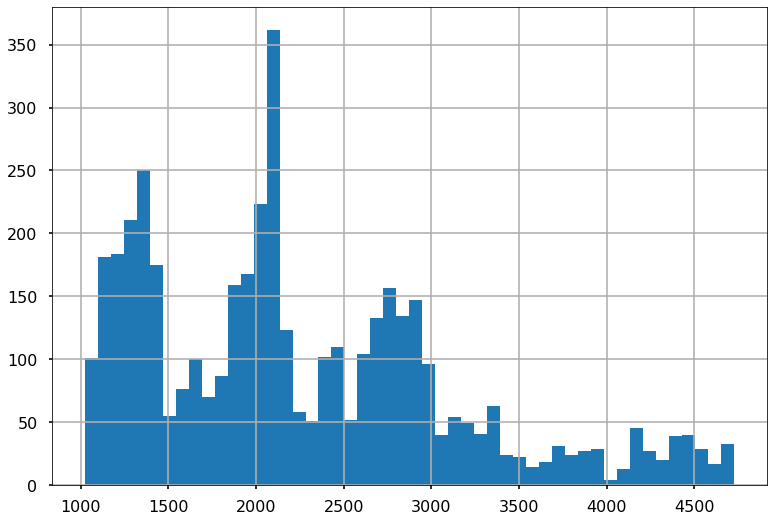

In [26]:
sp_df.Close.hist(bins=50)

Гистограмма не соответствует нормальному распределению, соответственно с большой вероятностью ряд не стационарный, проверим это с помощью статистических методов.

Разделим данные на составляющие - сезонность, тренд, остаточные изменения. Возьмем, только часть данных, так как при полных данных график сезонности не читаем.

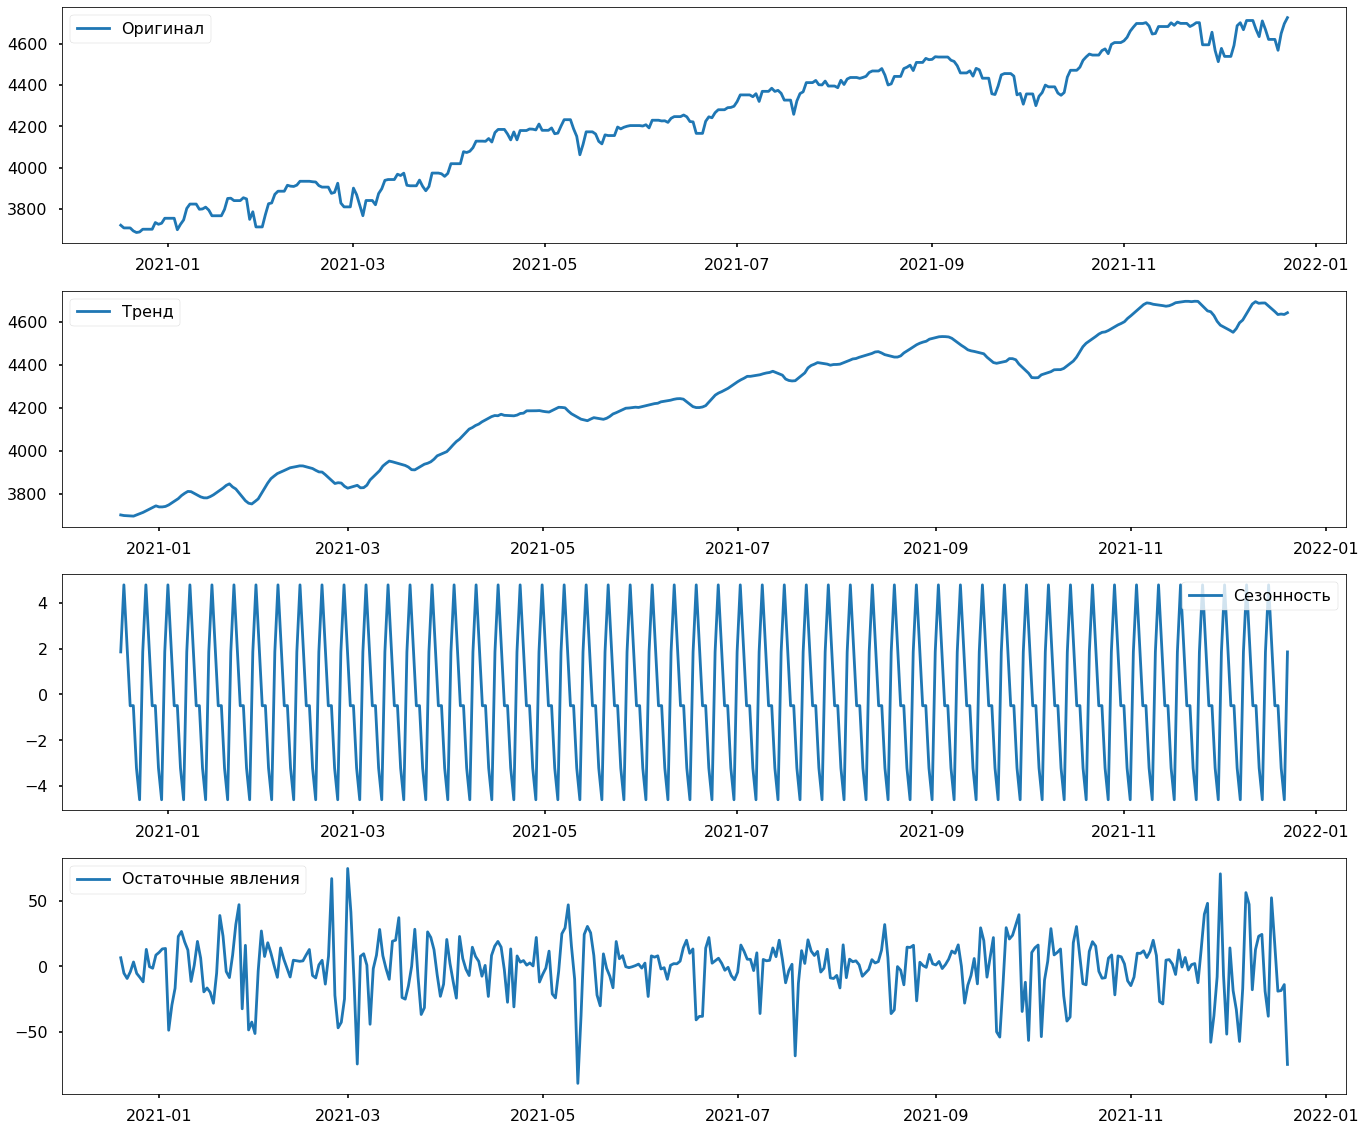

In [27]:
decompose_add=seasonal_decompose(sp_df['Close'][4000:], model='additive')
plt.figure(figsize=(23,20))
plt.subplot(411)
plt.plot(sp_df['Close'][4000:], label='Оригинал')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Тренд')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Сезонность')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Остаточные явления')
plt.legend(loc='best')

Данные не имеют выраженной сезонности, при этом имеют явный тренд.

Для более точной оценки стационарности применим тест Дики-Фуллера.

Примем гипотезы:

Нулевая гипотеза - процесс нестационарный

Альтернативная гипотеза - процесс стационарный

Используем пороговое значение, равное 0,05 (5%).

In [28]:
adf_test = adfuller(sp_df['Close'])
print('p-value: %f' % adf_test[1])

p-value: 0.997821


Вероятность (p-value) для данных стоимости индекса S&P 5000 существенно выше 0,05. Мы не можем отвергнуть нулевую гипотезу. Процесс нестационарный. 

In [29]:
adf_test_diff = adfuller(sp_df['Close'].diff().dropna())
print('p-value: %f' % adf_test_diff[1])

p-value: 0.000000


После дифференцирования первого порядка ряд становится стационарным.

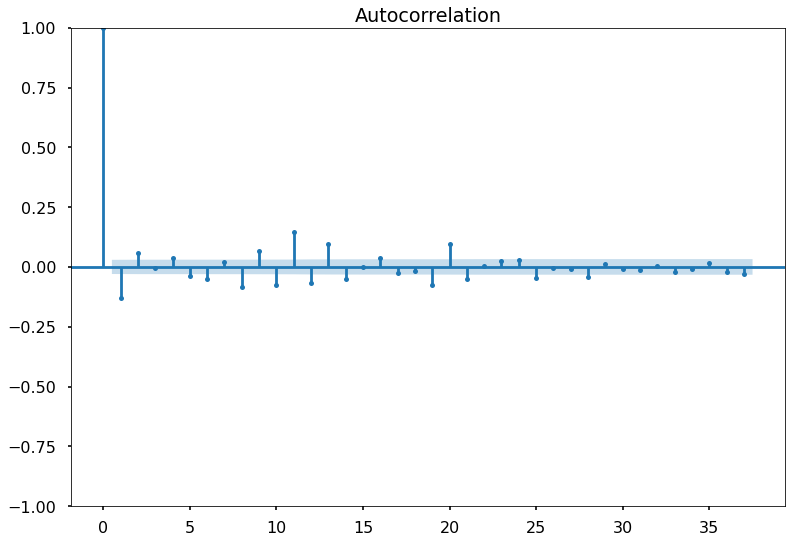

In [30]:
plt_acf(sp_df['Close'].diff().dropna())
plt.show()

# 3. Выбор моделей, обучение и предсказание

### 3.1.1. SARIMAX

In [9]:
# Подготавлиаем наборы параметров, для подбора лучшей комбинации
ps = range(1, 5)
d=1 
qs = range(1, 5)
Ps = range(0, 5)
D=1 
Qs = range(1, 3)
s = 12

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
prediction_period = 60

In [10]:
def optimizeSARIMA(parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=SARIMAX(sp_df['Close'][:(len(sp_df['Close'])-prediction_period)], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table, best_param, best_aic

In [82]:
warnings.filterwarnings("ignore") 
result_table, best_param, best_aic = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/160 [00:00<?, ?it/s]

In [83]:
result_table, best_param, best_aic

(       parameters           aic
 0    (4, 4, 0, 1)  38314.698022
 1    (4, 4, 2, 2)  38315.239710
 2    (4, 4, 4, 2)  38316.995748
 3    (4, 4, 1, 2)  38322.168222
 4    (3, 2, 1, 2)  38325.362301
 ..            ...           ...
 155  (2, 3, 1, 2)  38417.364479
 156  (3, 1, 0, 1)  38418.687835
 157  (2, 2, 0, 1)  38418.941459
 158  (1, 3, 0, 1)  38418.958784
 159  (3, 3, 4, 1)  38431.889668
 
 [160 rows x 2 columns],
 (4, 4, 0, 1),
 38314.6980221271)

In [11]:
best_param = [4, 4, 0, 1]
train_data = sp_df['Close'][:(len(sp_df['Close'])-prediction_period)]
test_data = sp_df['Close'][(len(sp_df['Close'])-prediction_period-1):]

In [39]:
# Обучаем модель
model_Sarimax = SARIMAX(train_data,  order=(best_param[0], d, best_param[1]), seasonal_order=(best_param[2], D, best_param[3], s))
model_fit = model_Sarimax.fit(disp=False)
# Делаем предсказание
predicted_data = model_fit.predict((len(sp_df['Close'])-prediction_period), len(sp_df['Close']))

Рассчитаем метрики - ошибки.

In [40]:
measure_error(test_data, predicted_data)

MAE: 74.979, MAPE: 1.637%, MSE: 7500.260, RMSE: 86.604, ME: -67.027, SD: 4713.022


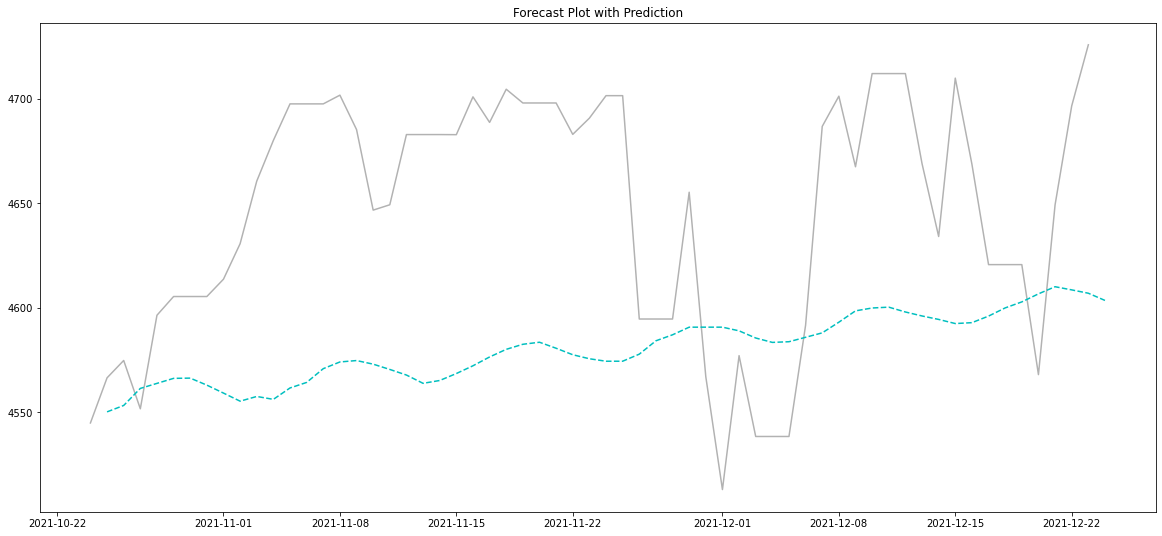

In [41]:
plot_reg_results_new(predicted_data, test_data, prediction_len=3)

### 3.1.2. SARIMAX с окном

Обучим модель и предскажем результат с окном установленной длины (по умолчанию 6)

In [34]:
train_prediction = train_model_SARIMAX (train_data, WINDOW, PRED_LENGTH)

In [35]:
train_offset=len(train_data)-len(train_prediction)

In [36]:
measure_error(train_data[:len(train_data)-train_offset], train_prediction)

MAE: 15.627, MAPE: 0.724%, MSE: 758.829, RMSE: 27.547, ME: -1.885, SD: 2377.568


Предскажем данные на тестовых данных с окном установленной длины (данные в прошлом 6, окно предсказания 3)

In [37]:
test_prediction = train_model_SARIMAX (test_data, WINDOW, PRED_LENGTH)

In [38]:
test_offset=len(test_data)-len(test_prediction)

In [39]:
measure_error(test_data[:len(test_data)-test_offset], test_prediction)

MAE: 28.599, MAPE: 0.617%, MSE: 1875.294, RMSE: 43.305, ME: -1.356, SD: 4646.015


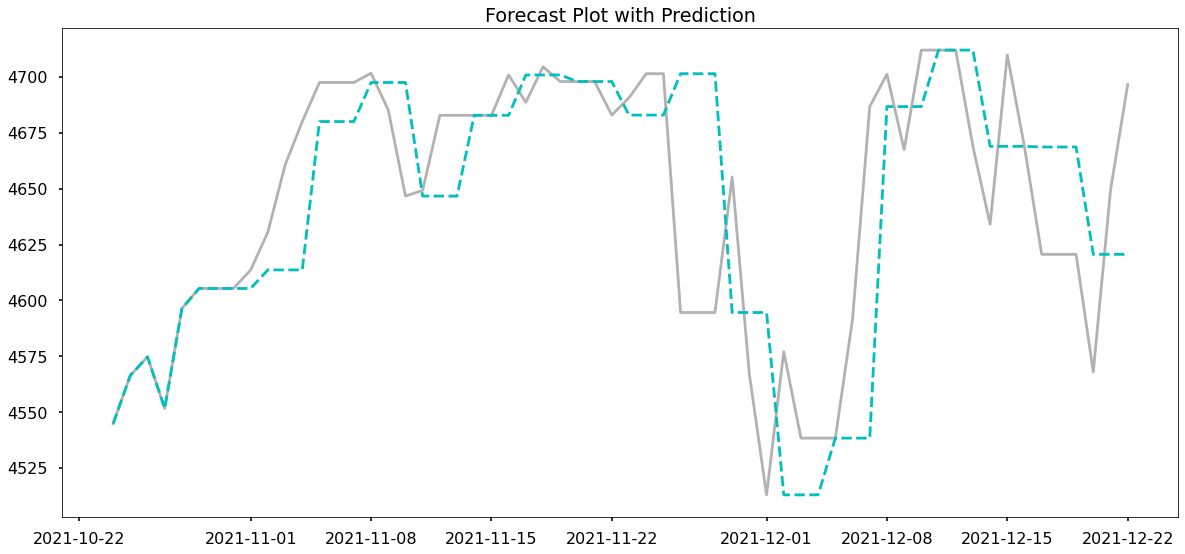

In [40]:
plot_reg_results_new(test_prediction, test_data[:len(test_data)-test_offset], prediction_len=3)

### 3.2.1. Prophet

https://facebook.github.io/prophet/

Требования к данным Prophet, для линейной регрессии, данные должны содержать две столбца данных с именами ds - даты событий и y - значение события.

In [12]:
train_data_new = pd.DataFrame(train_data)
train_data_prophet = train_data_new.reset_index()
train_data_prophet.columns = ['ds', 'y']

Подберем лучшие параметры для модели

In [44]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    m = prophet.Prophet(**params).fit(train_data_prophet)  # Fit model with given params
    df_cv = cross_validation(m, horizon='60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 130 forecasts with cutoffs between 2011-01-20 00:00:00 and 2021-08-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A8588EEDF0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 130 forecasts with cutoffs between 2011-01-20 00:00:00 and 2021-08-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A85887B820>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 130 forecasts with cutoffs between 2011-01-20 00:00:00 and 2021-08-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A85887B970>
INFO:prophet:Disabling daily seasonality. Run prophe

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  217.495772
1                     0.001                     0.10  217.310032
2                     0.001                     1.00  216.826232
3                     0.001                    10.00  217.518637
4                     0.010                     0.01  180.592730
5                     0.010                     0.10  180.810595
6                     0.010                     1.00  180.843246
7                     0.010                    10.00  180.646345
8                     0.100                     0.01  170.357197
9                     0.100                     0.10  172.677276
10                    0.100                     1.00  172.832691
11                    0.100                    10.00  172.869651
12                    0.500                     0.01  168.739993
13                    0.500                     0.10  171.512993
14                    0.5

In [46]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


Обучаем модель с подобранными параметрами на тренировочных данных и делаем предсказание без использования окна

In [14]:
m = prophet.Prophet(growth='linear', n_changepoints=120, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01, uncertainty_samples=60, )
m.add_country_holidays(country_name='US')
m.fit(train_data_prophet)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=prediction_period)
predicted_data_prophet = m.predict(future)
predicted_data_prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,1069.082887,976.618972,1212.877311,1069.082887,1069.082887,0.0,0.0,0.0,0.0,...,-1.276755,-1.276755,-1.276755,28.420742,28.420742,28.420742,0.0,0.0,0.0,1096.226874
1,2010-01-05,1071.292382,983.849105,1194.075767,1071.292382,1071.292382,0.0,0.0,0.0,0.0,...,-0.268508,-0.268508,-0.268508,28.960363,28.960363,28.960363,0.0,0.0,0.0,1099.984237
2,2010-01-06,1073.501877,963.975807,1253.286573,1073.501877,1073.501877,0.0,0.0,0.0,0.0,...,0.272032,0.272032,0.272032,29.418418,29.418418,29.418418,0.0,0.0,0.0,1103.192327
3,2010-01-07,1075.711371,933.386902,1244.375287,1075.711371,1075.711371,0.0,0.0,0.0,0.0,...,0.549292,0.549292,0.549292,29.766954,29.766954,29.766954,0.0,0.0,0.0,1106.027618
4,2010-01-08,1077.920866,1012.239040,1228.916455,1077.920866,1077.920866,0.0,0.0,0.0,0.0,...,1.163534,1.163534,1.163534,29.980056,29.980056,29.980056,0.0,0.0,0.0,1109.064456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,2021-12-19,4482.203829,4381.198163,4648.214953,4439.829130,4518.747227,0.0,0.0,0.0,0.0,...,-0.573991,-0.573991,-0.573991,29.188705,29.188705,29.188705,0.0,0.0,0.0,4510.818543
4368,2021-12-20,4484.218624,4391.944257,4622.894838,4440.866452,4521.856326,0.0,0.0,0.0,0.0,...,-1.276755,-1.276755,-1.276755,28.053281,28.053281,28.053281,0.0,0.0,0.0,4510.995150
4369,2021-12-21,4486.233419,4346.840529,4658.151243,4441.903774,4524.965426,0.0,0.0,0.0,0.0,...,-0.268508,-0.268508,-0.268508,27.064658,27.064658,27.064658,0.0,0.0,0.0,4513.029569
4370,2021-12-22,4488.248214,4364.487629,4635.530417,4443.063449,4528.074526,0.0,0.0,0.0,0.0,...,0.272032,0.272032,0.272032,26.235624,26.235624,26.235624,0.0,0.0,0.0,4514.755870


In [15]:
test_data_prophet = sp_df['Close'][(len(sp_df['Close'])-prediction_period-1):]
predicted_data_prophet_1 = predicted_data_prophet.set_index('ds')
predicted_data_prophet_future = predicted_data_prophet_1['yhat'][(len(sp_df['Close'])-prediction_period-1):]
measure_error(test_data_prophet, predicted_data_prophet_future)

MAE: 175.987, MAPE: 3.943%, MSE: 35157.875, RMSE: 187.504, ME: -175.987, SD: 4821.975


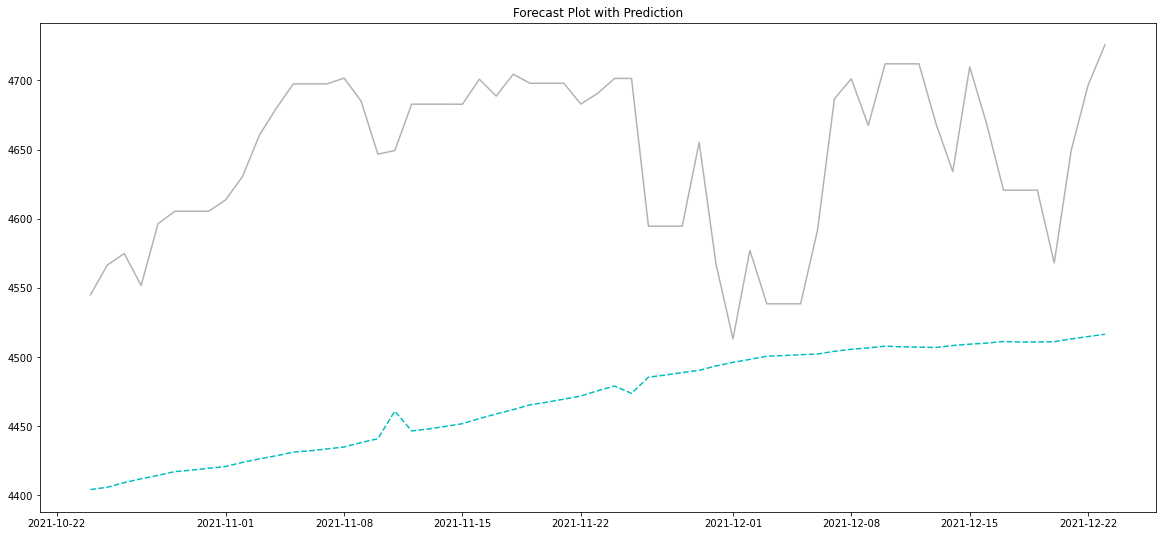

In [16]:
plot_reg_results_new(predicted_data_prophet_future, test_data_prophet, prediction_len=3)

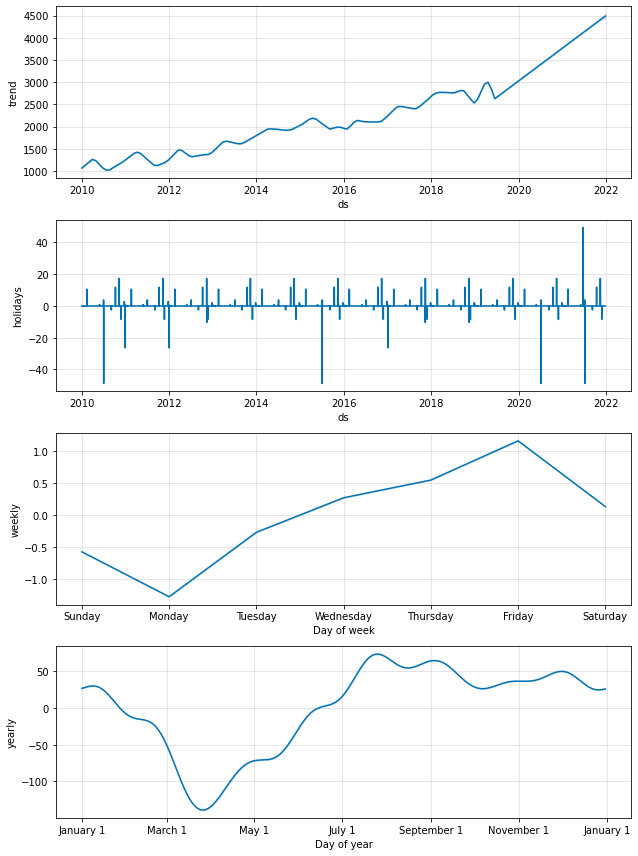

In [17]:
fig = m.plot_components(predicted_data_prophet)

### 3.2.2. Prophet с окном

Обучим Prophet и предскажем результат со сдвигом данных (окном предсказания равным - 3)

In [18]:
full_close_data = sp_df['Close']
train_data_new_window = pd.DataFrame(full_close_data)
train_data_new_window = train_data_new_window.reset_index()
train_data_new_window.columns = ['ds', 'y']

In [26]:
predicted_data_prophet = train_model_prophet(train_data_new_window, 60, WINDOW, PRED_LENGTH)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [32:17<00:00, 96.88s/it]


In [50]:
measure_error(test_data_prophet[1:], predicted_data_prophet['yhat'])

MAE: 124.211, MAPE: 2.760%, MSE: 20444.253, RMSE: 142.983, ME: -115.870, SD: 4763.528


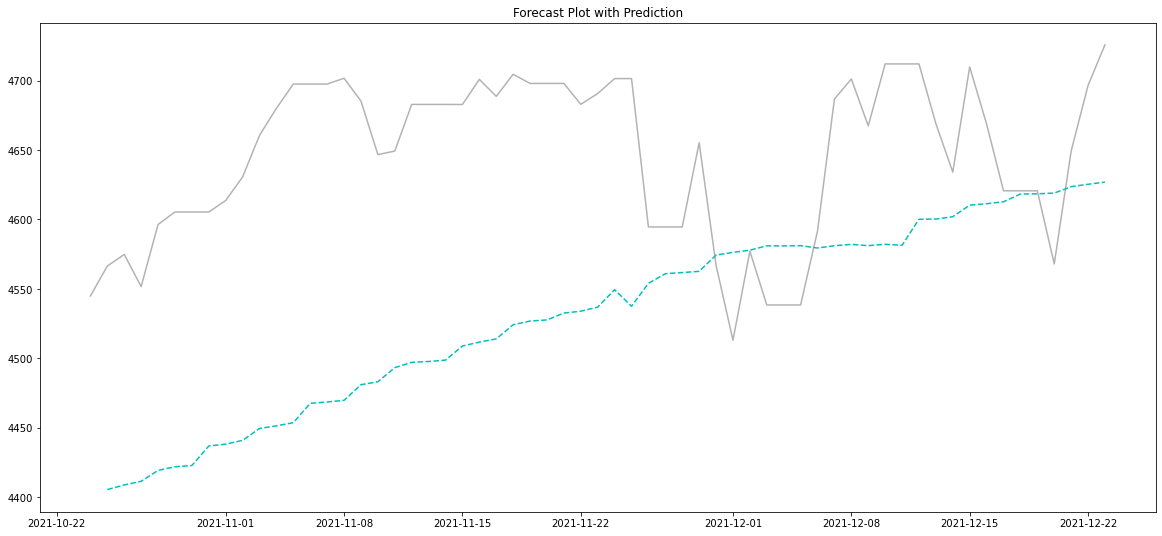

In [51]:
plot_reg_results_new(predicted_data_prophet, test_data_prophet, prediction_len=3)

### 3.3.1. Neural Prophet

https://neuralprophet.com/html/contents.html

Требования к данным NeuralProphet аналогичны требованиям Prophet, для линейной регрессии, данные должны содержать два столбца данных с именами ds - даты событий и y - значение события.

In [19]:
train_data_new_NeuralProphet = pd.DataFrame(sp_df['Close'])
train_data_NeuralProphet = train_data_new_NeuralProphet.reset_index()
train_data_NeuralProphet.columns = ['ds', 'y']
test_data_NeuralProphet=train_data_NeuralProphet[-60:]
train_data_NeuralProphet=train_data_NeuralProphet[:-60]

In [63]:
m_neural_wo_lags = NeuralProphet(n_changepoints=110, changepoints_range=0.9, trend_reg=120, seasonality_mode='multiplicative', num_hidden_layers=6, d_hidden=150,
                         yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, ar_sparsity=0.01, learning_rate=0.001,)
m_neural_wo_lags = m_neural_wo_lags.add_country_holidays("US", mode="additive", lower_window=-1, upper_window=1)
df_train, df_test = m_neural_wo_lags.split_df(train_data_NeuralProphet, freq='D', valid_p=0.02)

metrics = m_neural_wo_lags.fit(df_train, freq='D', validation_df=df_test)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO:NP.config:Note: Trend changepoint regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 126
INFO:NP.config:Auto-set epochs to 126
Epoch[126/126]: 100%|█| 126/126 [00:20<00:00,  6.16it/s, SmoothL1Loss=0.00306, MAE=143, RMSE=206, RegLoss=2.06e-7, MAE_


In [64]:
forecast = m_neural.predict(test_data_NeuralProphet)

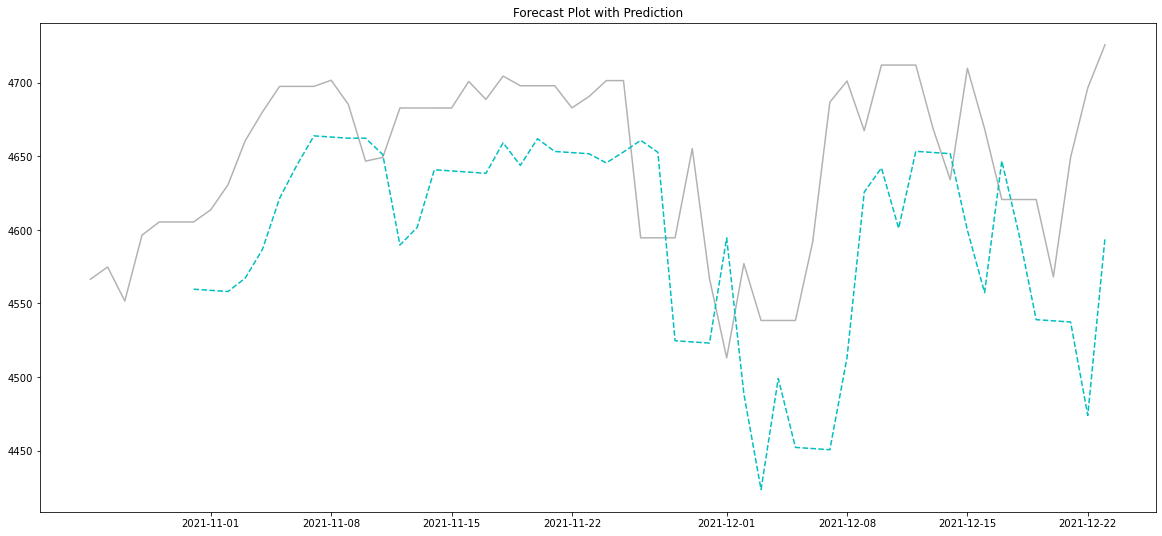

In [65]:
neural_forecast = forecast[['ds', 'yhat1']].set_index('ds')
test_data_neural = forecast[['ds', 'y']].set_index('ds')
plot_reg_results_new(neural_forecast, test_data_neural)

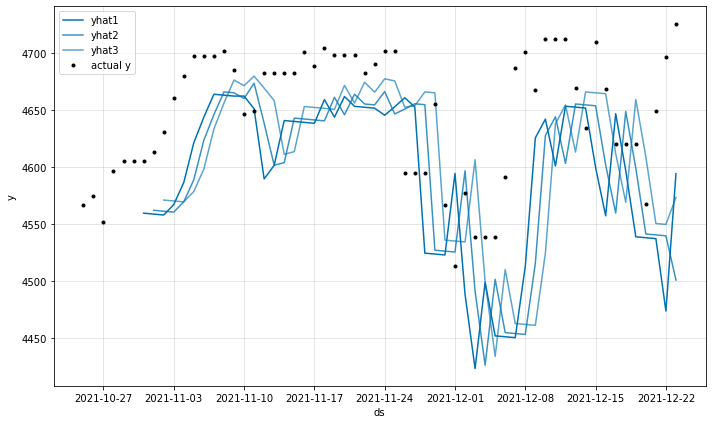

In [66]:
forecasts_plot = m_neural_wo_lags.plot(forecast)

In [67]:
measure_error(test_data_neural.y[lags:], neural_forecast.yhat1[lags:])

MAE: 71.031, MAPE: 1.557%, MSE: 7336.487, RMSE: 85.653, ME: -61.133, SD: 4715.881


### 3.3.2. NeuralProphet с окном

In [84]:
lags=6
m_neural = NeuralProphet(n_changepoints=110, changepoints_range=0.9, trend_reg=120, seasonality_mode='multiplicative', num_hidden_layers=6, d_hidden=150, n_lags=lags, n_forecasts=3, 
                         yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, ar_sparsity=0.015, learning_rate=0.001, loss_func='MAE')
m_neural = m_neural.add_country_holidays("US", mode="additive", lower_window=-1, upper_window=1)
df_train, df_test = m_neural.split_df(train_data_NeuralProphet, freq='D', valid_p=0.02)

metrics = m_neural.fit(df_train, freq='D', validation_df=df_test)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO:NP.config:Note: Trend changepoint regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 126
INFO:NP.config:Auto-set epochs to 126
Epoch[126/126]: 100%|█| 126/126 [01:34<00:00,  1.33it/s, L1Loss=0.00678, MAE=18.2, RMSE=28.4, RegLoss=0.595, L1Loss_val


In [85]:
forecast = m_neural.predict(test_data_NeuralProphet)

In [86]:
# forecast = m_neural.predict(df_test)

In [87]:
forecast.head(10)

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,ar1,ar2,...,event_Juneteenth National Independence Day,event_Labor Day,event_Martin Luther King Jr. Day,event_Memorial Day,event_New Year's Day,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday
0,2021-10-25,4566.479980,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2021-10-26,4574.790039,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2021-10-27,4551.680176,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2021-10-28,4596.419922,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2021-10-29,4605.379883,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
5,2021-10-30,4605.379883,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
6,2021-10-31,4605.379883,4607.644043,2.26416,None,NaN,None,NaN,6566.343262,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2021-11-01,4613.669922,4606.473633,-7.196289,4611.780273,-1.889648,None,NaN,6565.202637,6570.509277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2021-11-02,4630.649902,4612.630859,-18.019043,4610.282715,-20.367188,4615.973145,-14.676758,6571.389648,6569.041504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2021-11-03,4660.569824,4628.866699,-31.703125,4616.432129,-44.137695,4614.681641,-45.888184,6587.655273,6575.221191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


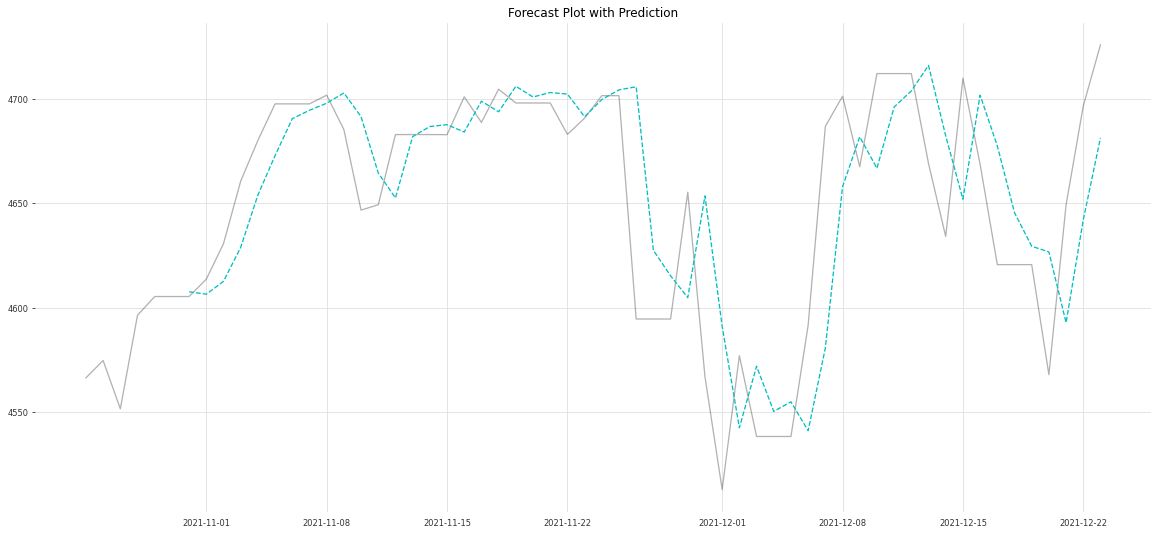

In [88]:
neural_forecast = forecast[['ds', 'yhat1']].set_index('ds')
test_data_neural = forecast[['ds', 'y']].set_index('ds')
plot_reg_results_new(neural_forecast, test_data_neural)

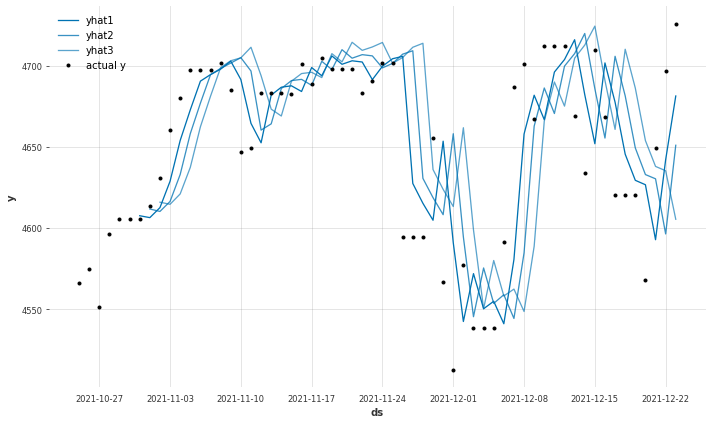

In [89]:
forecasts_plot = m_neural.plot(forecast)

In [90]:
measure_error(test_data_neural.y[-60+lags:], neural_forecast.yhat1[-60+lags:])

MAE: 29.075, MAPE: 0.626%, MSE: 1530.219, RMSE: 39.118, ME: 1.293, SD: 4653.460


### 3.4.1. Библиотека Darts

In [20]:
import darts
from darts import TimeSeries
from darts import models
from darts.metrics import mape, rmse, mae, mse
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression

In [21]:
pred_len = 60
train_data_darts = TimeSeries.from_dataframe(train_data_NeuralProphet [:-pred_len], 'ds', 'y')
test_data_darts = TimeSeries.from_dataframe(train_data_NeuralProphet [-pred_len:], 'ds', 'y')
transformer_darts = Scaler()
train_data_darts_transformed = transformer_darts.fit_transform(train_data_darts)
test_data_darts_transformed = transformer_darts.transform(test_data_darts)

In [22]:
FIG_SIZE = (20, 10)
plt.rc('figure', figsize=FIG_SIZE)
SimpleModel = ['NaiveMean', 'LinearRegressionModel', 'NaiveDrift', 'RandomForest', 'NaiveSeasonal', 'VARIMA', 'ARIMA', 'AutoARIMA', 'Theta', 'FourTheta', 'FFT', 'ExponentialSmoothing', 'Prophet']

def eval_model(model):
    if model.__class__.__name__ == 'VARIMA':
        model.fit(train_data_darts, test_data_darts)
    elif model.__class__.__name__ in SimpleModel:
        model.fit(train_data_darts)
    else:
        model.fit(train_data_darts, verbose=1)
    forecast = model.predict(pred_len)
    print('model {} obtains MAE: {:.3f}, MAPE: {:.3f}%, MSE: {:.3f}, RMSE: {:.3f}'.format(model, 
                                                                                          mae(test_data_darts, forecast), 
                                                                                          mape(test_data_darts, forecast), 
                                                                                          mse(test_data_darts, forecast), 
                                                                                          rmse(test_data_darts, forecast)))
    train_data_darts[-365:].plot(label='training')
    test_data_darts[-365:].plot(label='validation')
    forecast[-365:].plot(label='prediction')
    plt.legend();

In [23]:
def eval_model_RNN(model):
    if model.__class__.__name__ in SimpleModel:
        model.fit(train_data_darts_transformed)
    else:
        model.fit(train_data_darts_transformed, verbose=1)
    forecast = model.predict(pred_len)
    inverse_forecast = transformer_darts.inverse_transform(forecast)
    print('model {} obtains MAE: {:.3f}, MAPE: {:.3f}%, MSE: {:.3f}, RMSE: {:.3f}'.format(model, 
                                                                                          mae(test_data_darts, inverse_forecast), 
                                                                                          mape(test_data_darts, inverse_forecast), 
                                                                                          mse(test_data_darts, inverse_forecast), 
                                                                                          rmse(test_data_darts, inverse_forecast)))
    train_data_darts[-365:].plot(label='training')
    test_data_darts[-365:].plot(label='validation')
    # forecast[-365:].plot(label='prediction')
    inverse_forecast[-365:].plot(label='prediction')
    plt.legend();

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7 obtains MAE: 63.681, MAPE: 1.370%, MSE: 5183.464, RMSE: 71.996


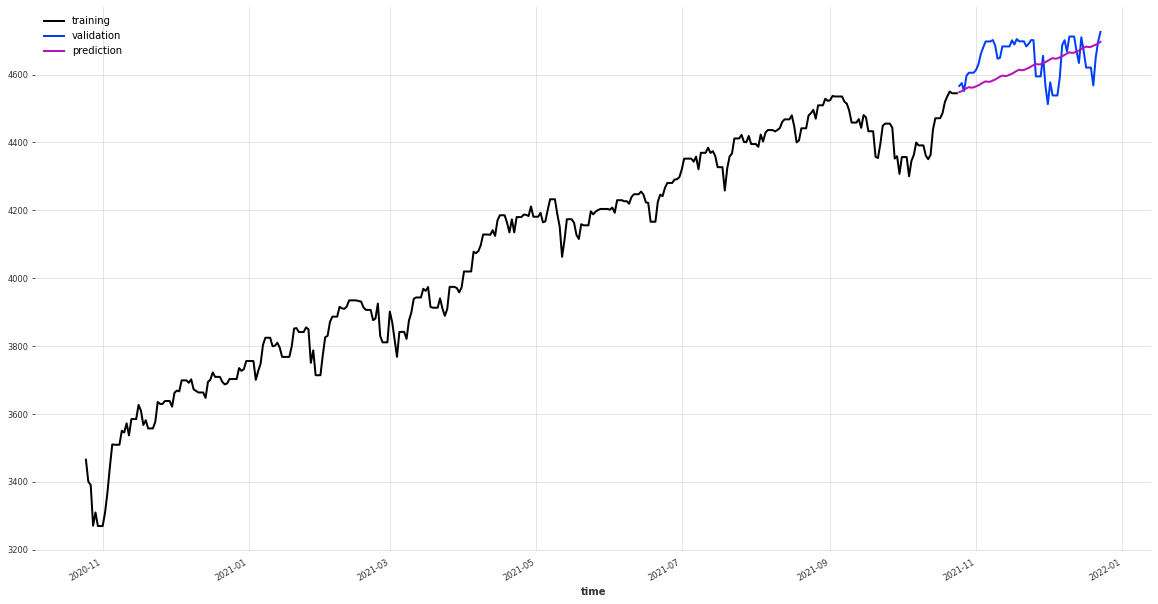

In [244]:
eval_model(models.ExponentialSmoothing())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model Prophet obtains MAE: 248.721, MAPE: 5.338%, MSE: 66396.895, RMSE: 257.676


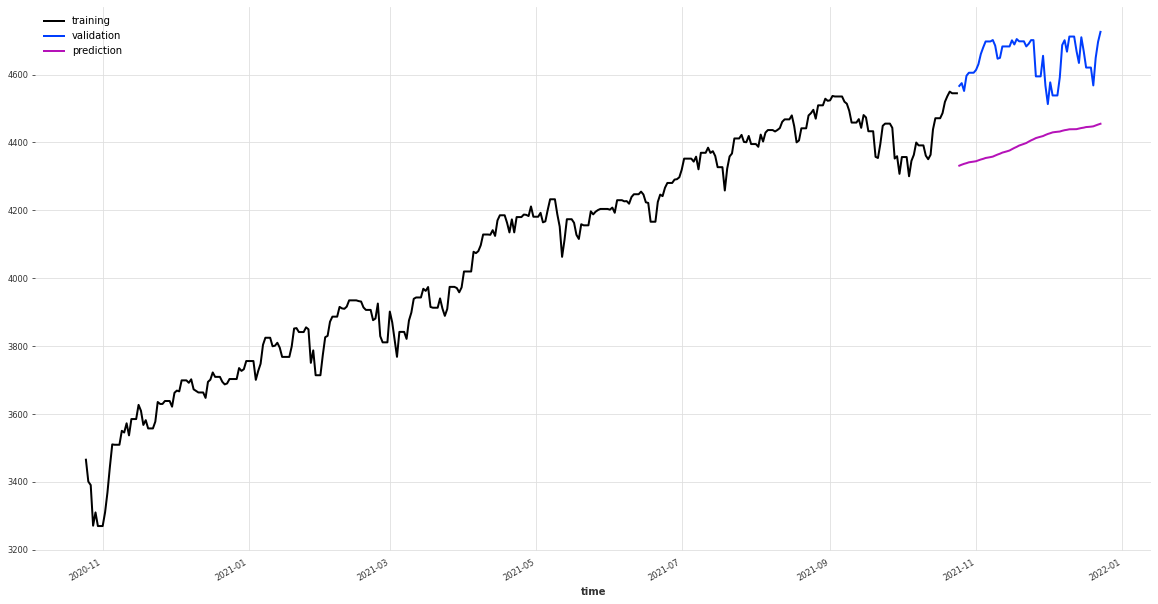

In [247]:
eval_model(models.Prophet())

model ARIMA(12, 1, 0) obtains MAE: 65.942, MAPE: 1.497%, MSE: 6722.159, RMSE: 81.989


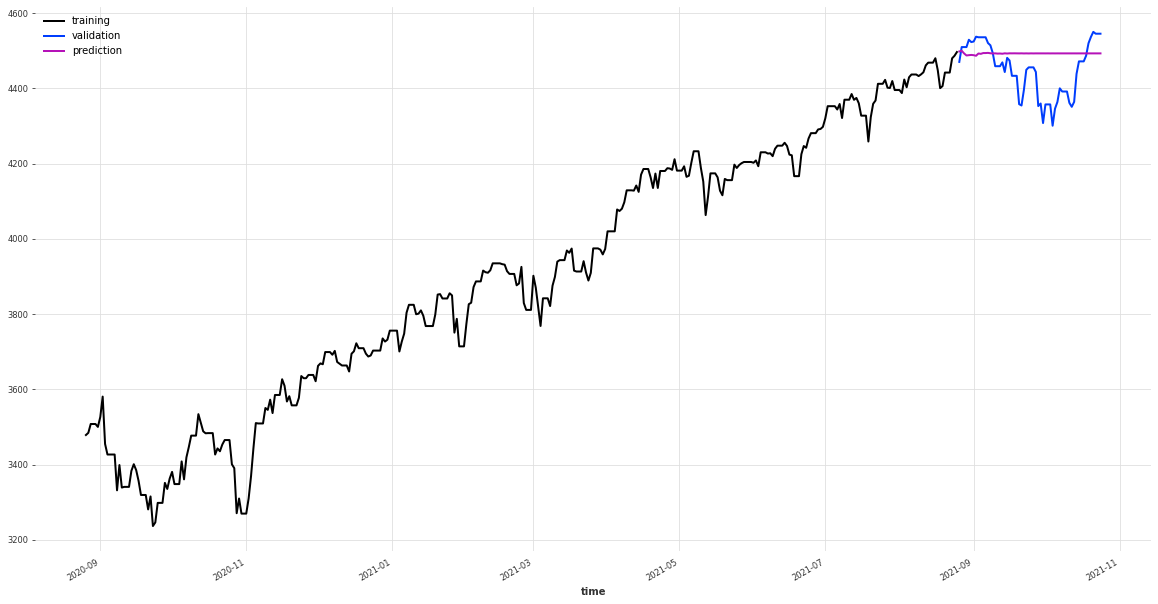

In [15]:
eval_model(darts.models.ARIMA())

model Auto-ARIMA obtains MAE: 85.155, MAPE: 1.822%, MSE: 9328.666, RMSE: 96.585


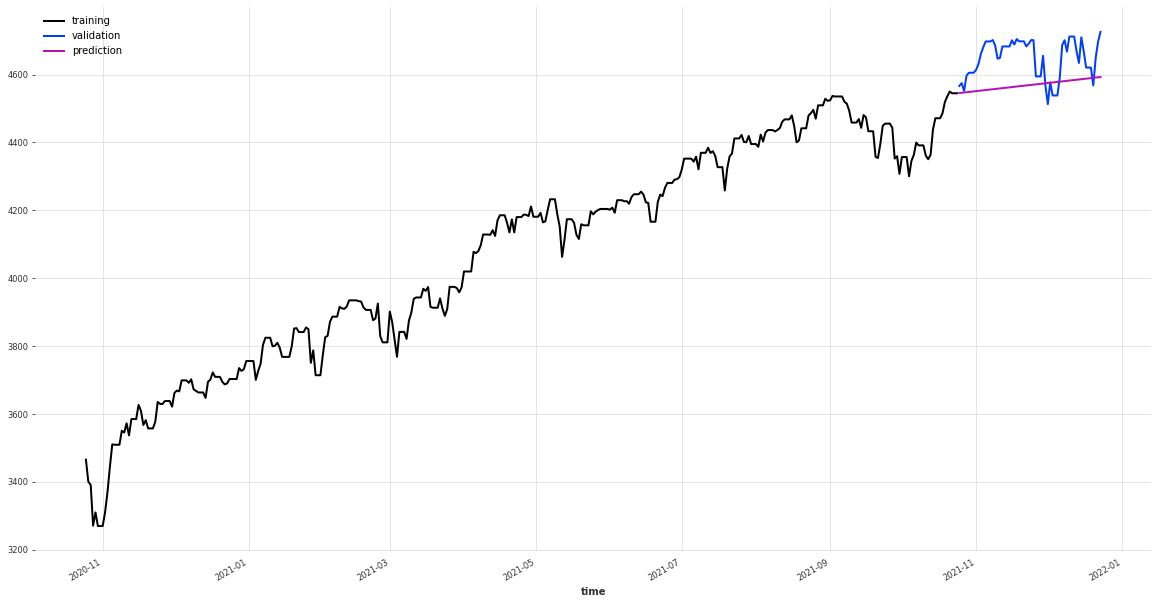

In [236]:
eval_model(darts.models.AutoARIMA())

[2022-01-08 20:46:37,919] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 581
[2022-01-08 20:46:37,919] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 581
INFO:darts.models.forecasting.theta:Theta model inferred seasonality of training series: 581


model Theta(2) obtains MAE: 95.106, MAPE: 2.039%, MSE: 11089.500, RMSE: 105.307


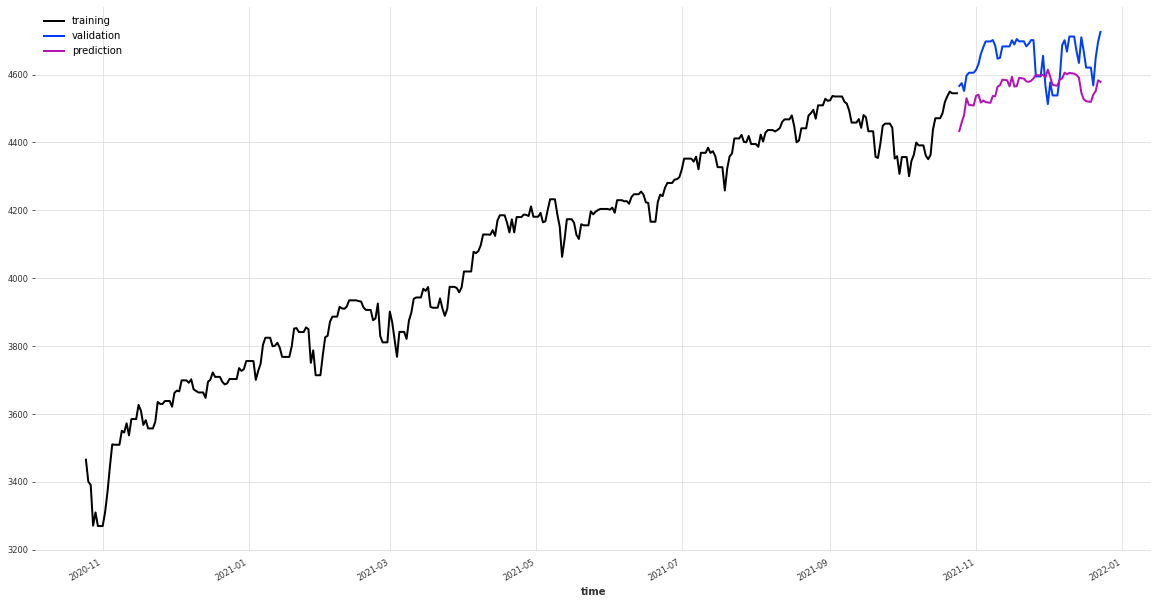

In [237]:
eval_model(darts.models.Theta())

[2022-01-08 20:46:44,696] INFO | darts.models.forecasting.theta | FourTheta model inferred seasonality of training series: 581
[2022-01-08 20:46:44,696] INFO | darts.models.forecasting.theta | FourTheta model inferred seasonality of training series: 581
INFO:darts.models.forecasting.theta:FourTheta model inferred seasonality of training series: 581


model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAE: 95.107, MAPE: 2.039%, MSE: 11089.857, RMSE: 105.308


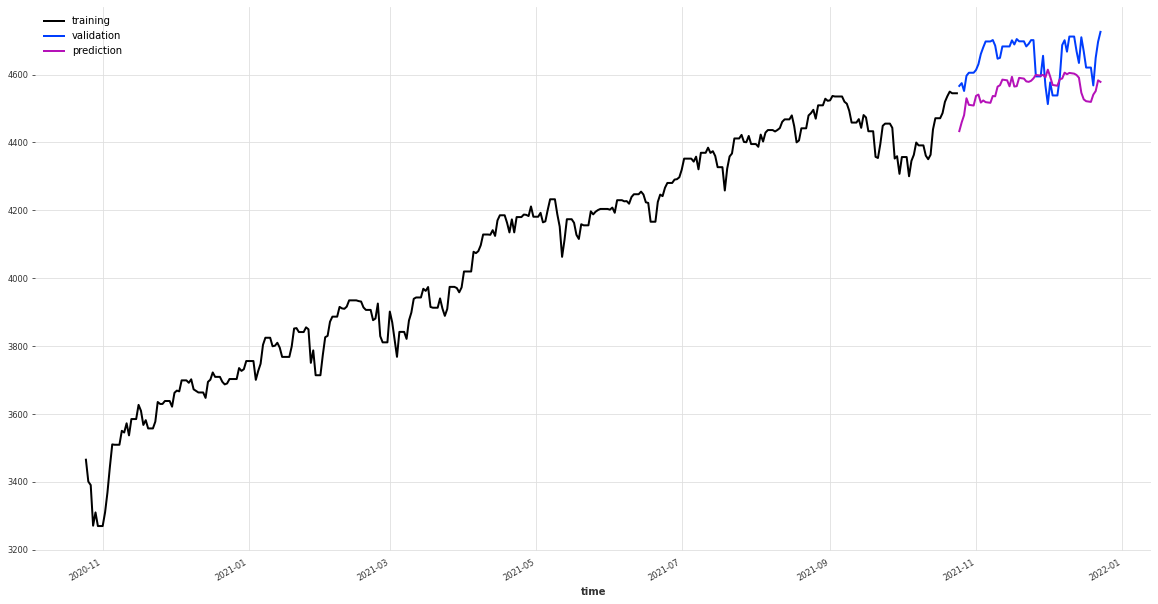

In [238]:
eval_model(darts.models.FourTheta())

model FFT(nr_freqs_to_keep=None, trend=poly) obtains MAE: 198.647, MAPE: 4.262%, MSE: 42706.914, RMSE: 206.657


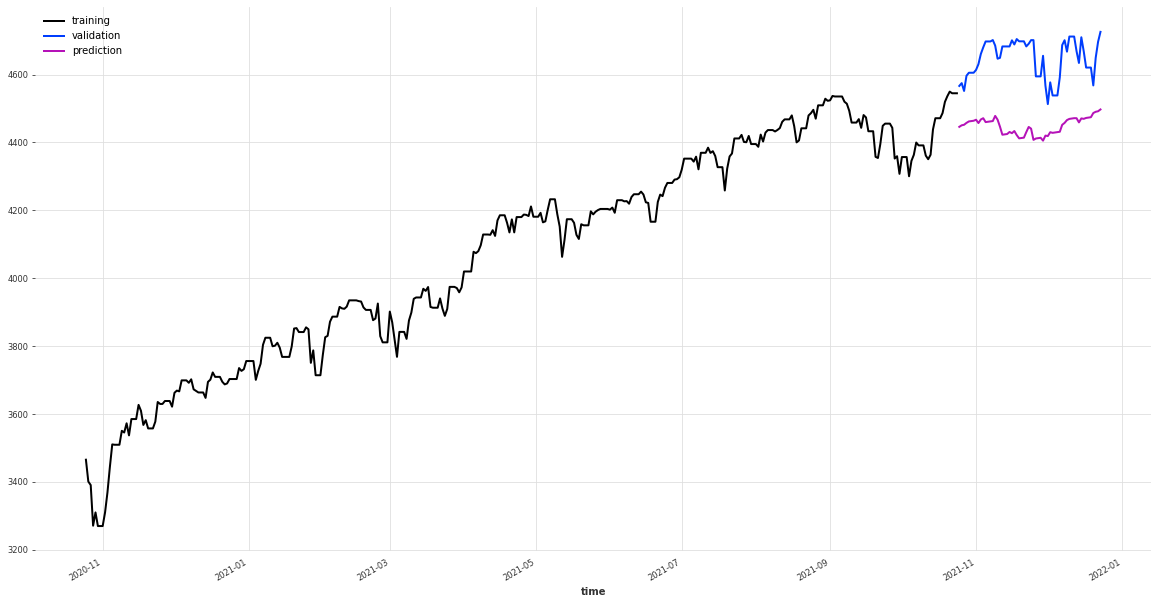

In [241]:
eval_model(darts.models.FFT(trend='poly', nr_freqs_to_keep=None))

[2022-01-12 23:14:28,901] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4202 samples.
[2022-01-12 23:14:28,901] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4202 samples.
[2022-01-12 23:14:28,906] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 23:14:28,906] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.rnn_model.RNNModel object at 0x00000266D0018DF0> obtains MAE: 96.448, MAPE: 2.147%, MSE: 13181.793, RMSE: 114.812


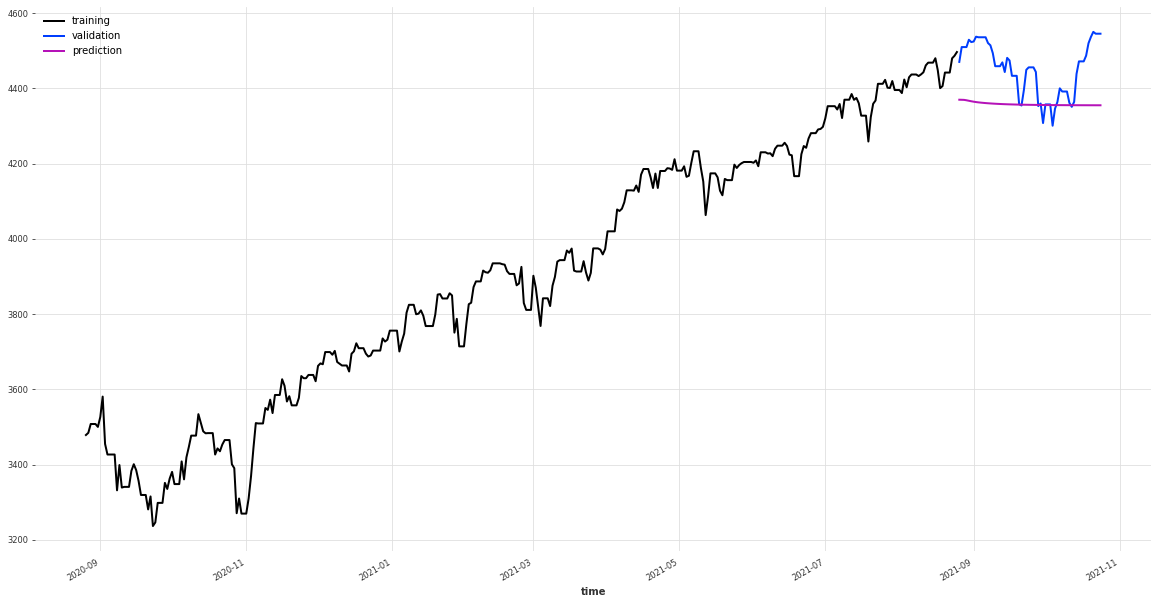

In [46]:
eval_model_RNN(darts.models.RNNModel(
    model='LSTM',
    hidden_dim=100,
    n_rnn_layers=5,
    dropout=0.5,
    batch_size=30,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    model_name='S&P 500 LSTM',
    log_tensorboard=True,
    random_state=42,
    training_length=50,
    input_chunk_length=30,
    force_reset=True,
    save_checkpoints=True
))

[2022-01-12 23:09:39,169] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4202 samples.
[2022-01-12 23:09:39,169] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4202 samples.
[2022-01-12 23:09:39,174] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 23:09:39,174] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.rnn_model.RNNModel object at 0x00000266D0BD8220> obtains MAE: 66.866, MAPE: 1.503%, MSE: 5973.825, RMSE: 77.291


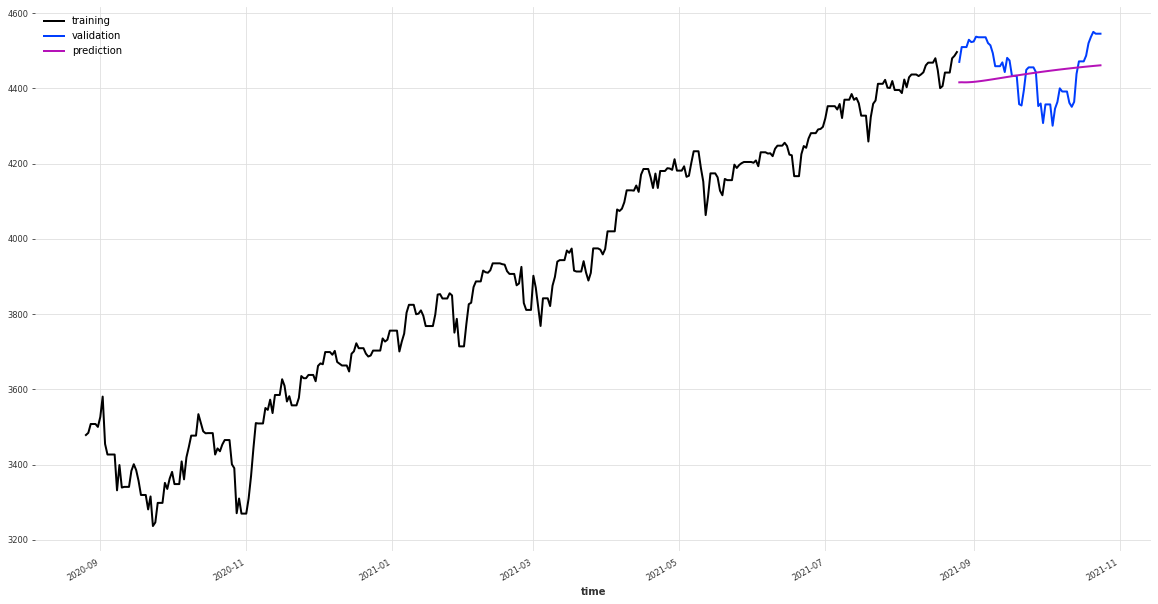

In [45]:
eval_model_RNN(darts.models.RNNModel(
    model='GRU',
    hidden_dim=120,
    n_rnn_layers=4,
    dropout=0.5,
    batch_size=30,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    model_name='S&P 500 GRU',
    log_tensorboard=True,
    random_state=42,
    training_length=50,
    input_chunk_length=20,
    force_reset=True,
    save_checkpoints=True
))

[2022-01-12 23:07:32,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4238 samples.
[2022-01-12 23:07:32,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4238 samples.
[2022-01-12 23:07:32,879] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 23:07:32,879] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.rnn_model.RNNModel object at 0x00000266D0B8E370> obtains MAE: 65.315, MAPE: 1.485%, MSE: 6992.370, RMSE: 83.620


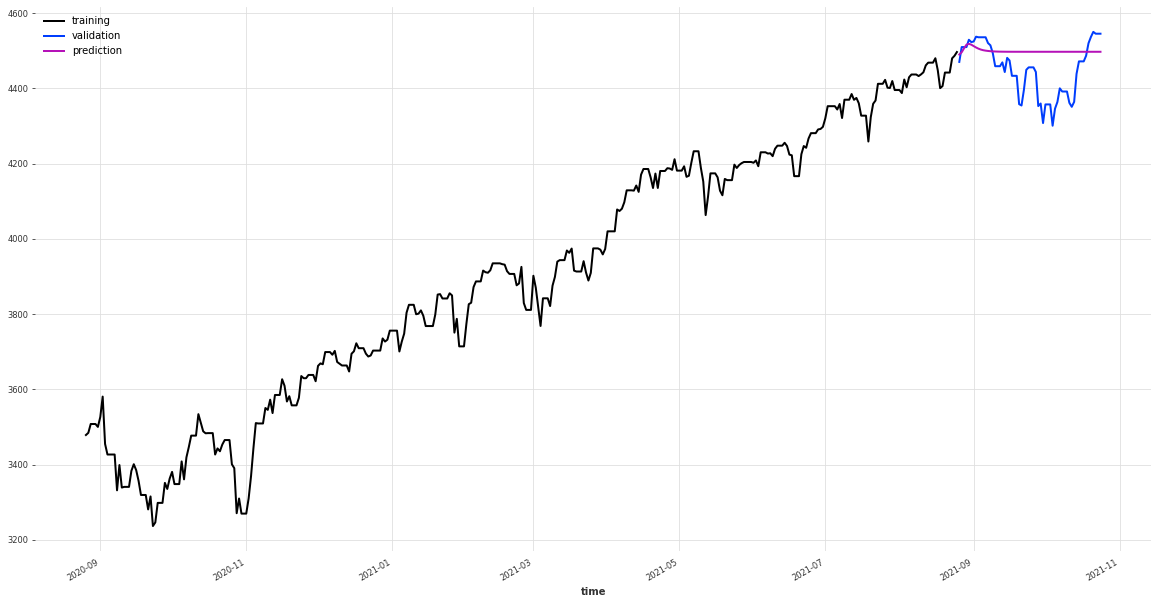

In [44]:
eval_model_RNN(darts.models.RNNModel(
    model='RNN',
    hidden_dim=150,
    n_rnn_layers=3,
    dropout=0.7,
    batch_size=14,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    model_name='S&P 500 RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=14,
    input_chunk_length=6,
    force_reset=True,
    save_checkpoints=True
))

[2022-01-12 22:55:54,922] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4092 samples.
[2022-01-12 22:55:54,922] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4092 samples.
[2022-01-12 22:55:54,925] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 22:55:54,925] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.block_rnn_model.BlockRNNModel object at 0x00000266C70FF130> obtains MAE: 69.441, MAPE: 1.550%, MSE: 6727.893, RMSE: 82.024


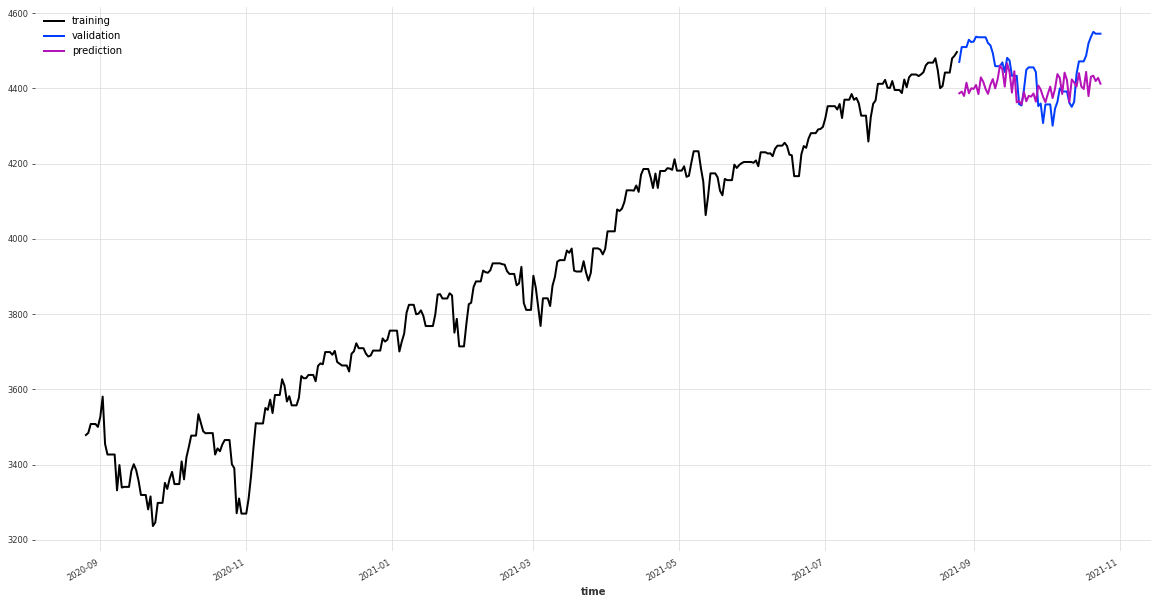

In [37]:
eval_model_RNN(darts.models.BlockRNNModel(
    model='RNN',
    hidden_size=100,
    n_rnn_layers=5,
    dropout=0.3,
    batch_size=32,
    n_epochs=10,
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    model_name='S&P 500 B_RNN',
    log_tensorboard=True,
    random_state=42,
    input_chunk_length=125,
    output_chunk_length=36,
    force_reset=True,
    save_checkpoints=True
))

[2022-01-12 22:34:05,793] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4092 samples.
[2022-01-12 22:34:05,793] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4092 samples.
[2022-01-12 22:34:05,797] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 22:34:05,797] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.block_rnn_model.BlockRNNModel object at 0x00000266D0D0B370> obtains MAE: 134.554, MAPE: 3.054%, MSE: 26628.797, RMSE: 163.183


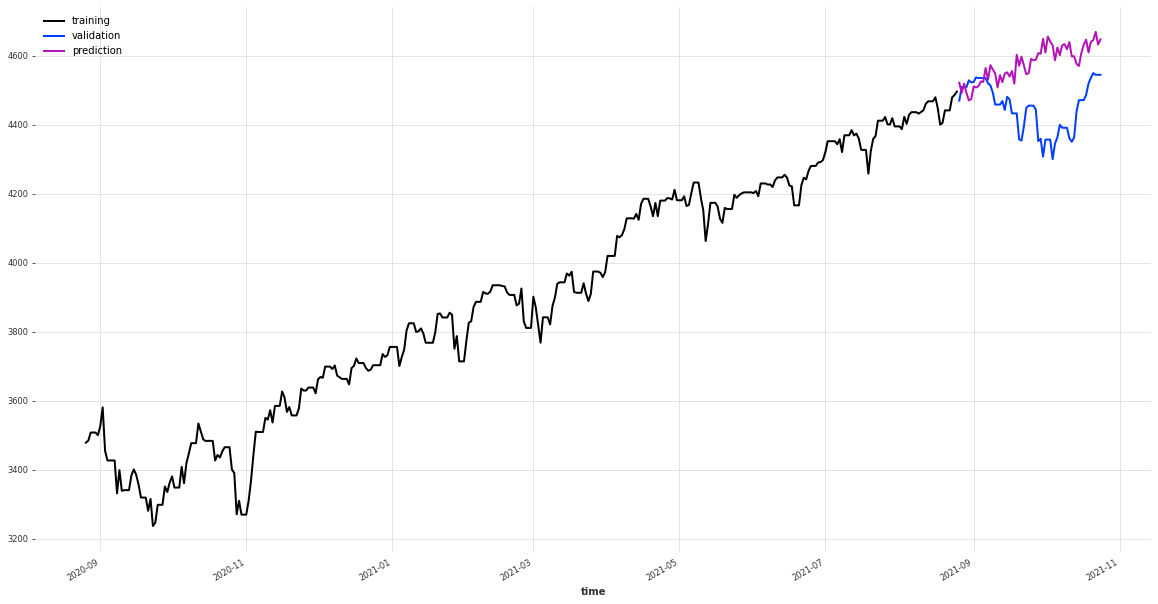

In [32]:
eval_model_RNN(darts.models.BlockRNNModel(
    model='GRU',
    hidden_size=100,
    n_rnn_layers=3,
    dropout=0.3,
    batch_size=32,
    n_epochs=10,
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    model_name='S&P 500 B_GRU',
    log_tensorboard=True,
    random_state=42,
    input_chunk_length=125,
    output_chunk_length=36,
    force_reset=True,
    save_checkpoints=True
))

[2022-01-12 22:39:17,823] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4092 samples.
[2022-01-12 22:39:17,823] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4092 samples.
[2022-01-12 22:39:17,827] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 22:39:17,827] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.block_rnn_model.BlockRNNModel object at 0x00000266D1F0AB80> obtains MAE: 85.451, MAPE: 1.907%, MSE: 10426.307, RMSE: 102.109


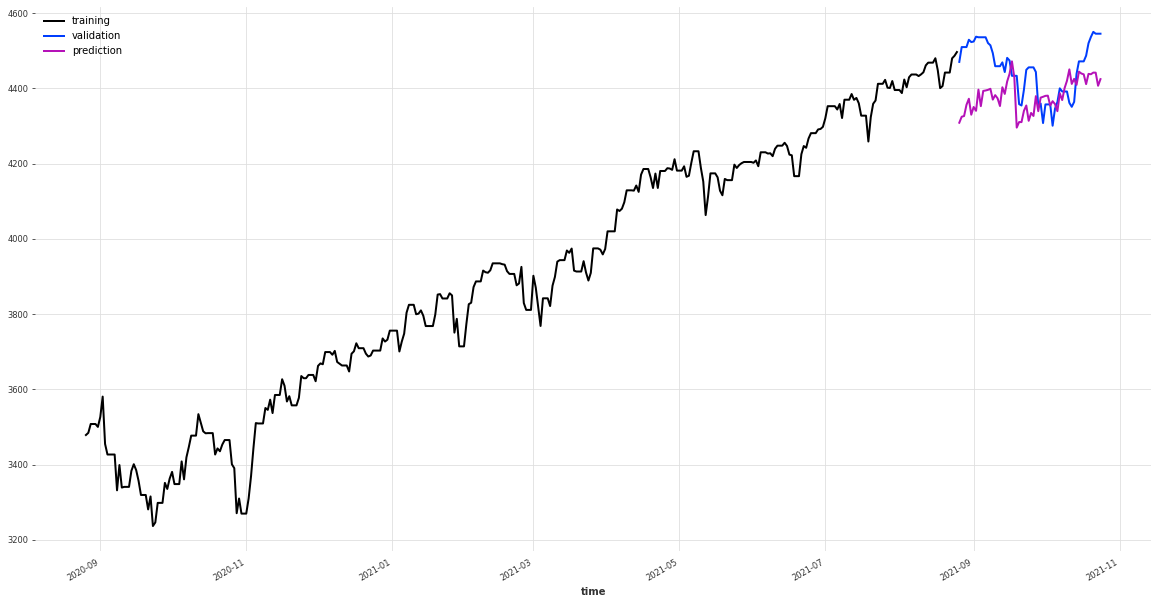

In [33]:
eval_model_RNN(darts.models.BlockRNNModel(
    model='LSTM',
    hidden_size=100,
    n_rnn_layers=3,
    dropout=0.3,
    batch_size=32,
    n_epochs=10,
    nr_epochs_val_period=1,
    model_name='S&P 500 B_LSTM',
    log_tensorboard=True,
    random_state=42,
    input_chunk_length=125,
    output_chunk_length=36,
    force_reset=True,
    save_checkpoints=True
))

[2022-01-12 22:46:04,226] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4208 samples.
[2022-01-12 22:46:04,226] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4208 samples.
[2022-01-12 22:46:04,947] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 22:46:04,947] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.nbeats.NBEATSModel object at 0x00000266D1F98AC0> obtains MAE: 100.599, MAPE: 2.282%, MSE: 16381.359, RMSE: 127.990


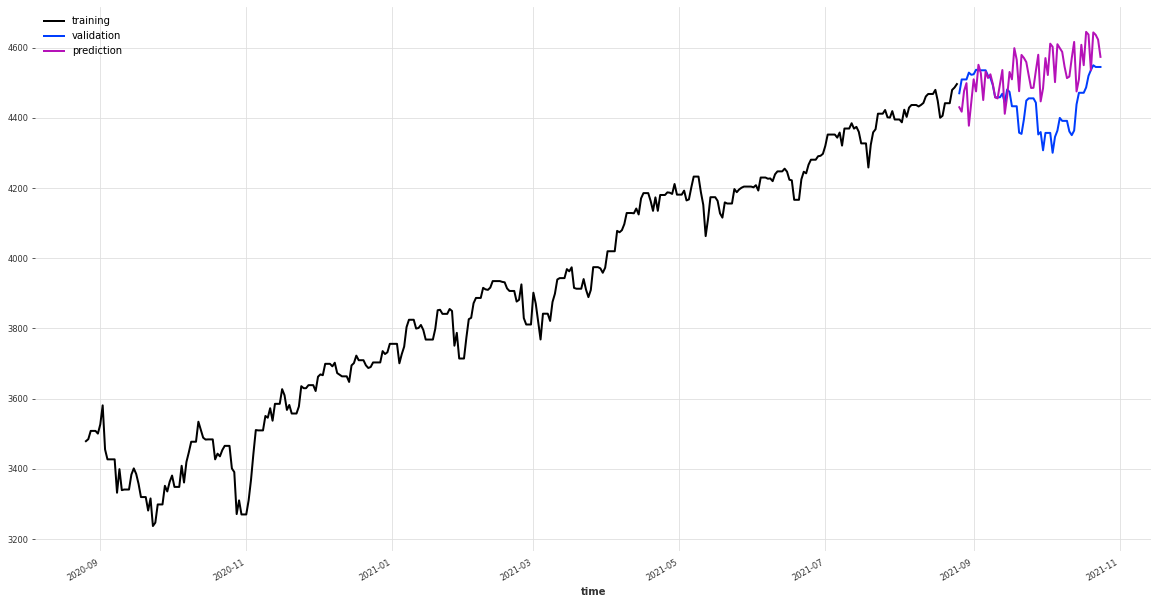

In [34]:
eval_model_RNN(darts.models.NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=15,
    generic_architecture=True,
    num_stacks=144,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='nbeats_run'))

[2022-01-13 18:27:20,572] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4216 samples.
[2022-01-13 18:27:20,572] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4216 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 4216 samples.
[2022-01-13 18:27:20,618] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-13 18:27:20,618] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

model <darts.models.forecasting.nbeats.NBEATSModel object at 0x00000197FA18ED30> obtains MAE: 102.432, MAPE: 2.327%, MSE: 15763.604, RMSE: 125.553


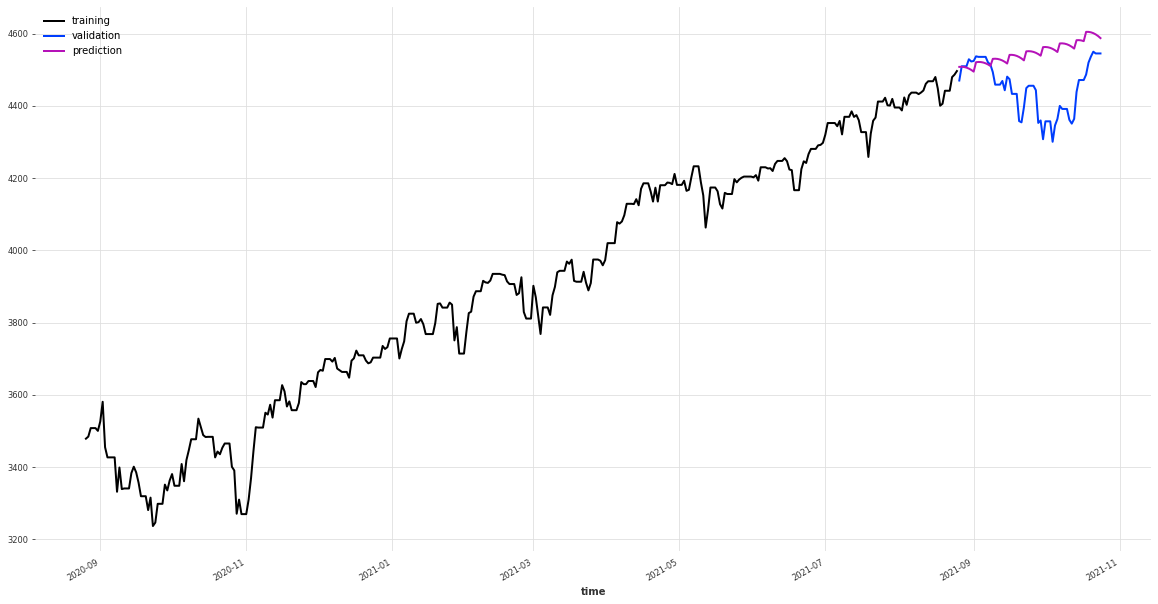

In [24]:
eval_model_RNN(darts.models.NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    num_blocks=3,
    num_layers=4,
    generic_architecture=False,
    layer_widths=512,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    nr_epochs_val_period=3,
    batch_size=200,
    model_name='nbeats_run_false'))

[2022-01-13 18:40:09,995] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4163 samples.
[2022-01-13 18:40:09,995] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4163 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 4163 samples.
[2022-01-13 18:40:09,997] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 4
[2022-01-13 18:40:09,997] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 4
INFO:darts.models.forecasting.tcn_model:Number of layers chosen: 4
[2022-01-13 18:40:10,000] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-13 18:40:10,000] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/30 [00:00<?, ?it/s]

model <darts.models.forecasting.tcn_model.TCNModel object at 0x000001978549C8B0> obtains MAE: 102.629, MAPE: 2.328%, MSE: 15269.873, RMSE: 123.571


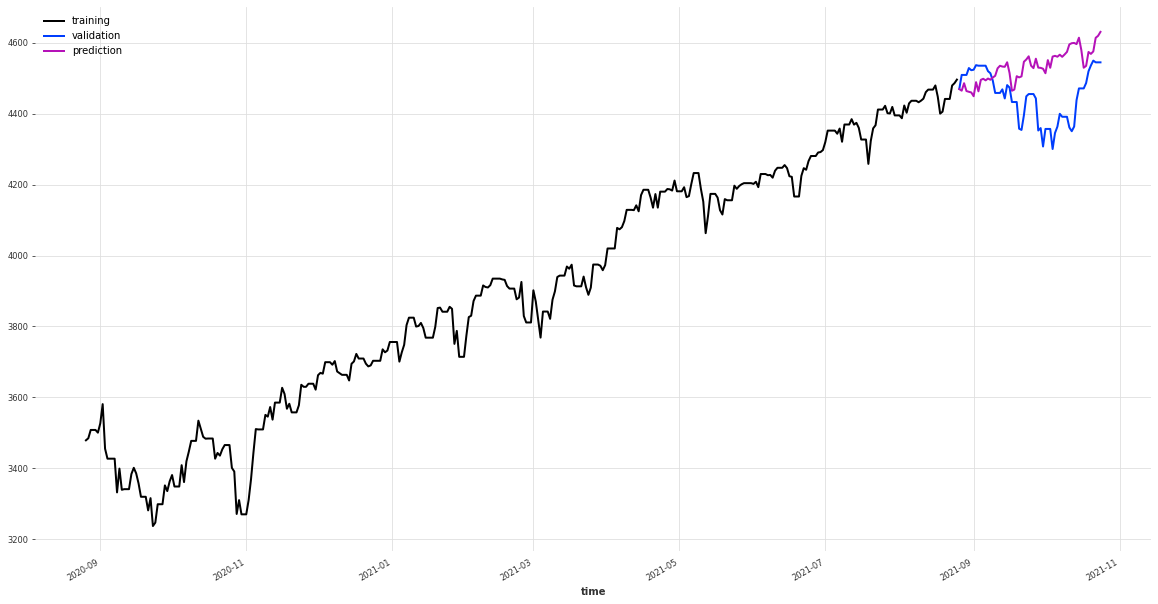

In [32]:
eval_model_RNN(darts.models.TCNModel(
    input_chunk_length=60,
    output_chunk_length=30,
    kernel_size=2,
    batch_size=32,
    num_filters=8,
    dilation_base=3,
    dropout=0.3,
    n_epochs=30,
    random_state=0,
    likelihood=GaussianLikelihood()))

[2022-01-13 19:20:37,391] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4103 samples.
[2022-01-13 19:20:37,391] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4103 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 4103 samples.
[2022-01-13 19:20:37,404] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-13 19:20:37,404] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.tft_model.TFTModel object at 0x00000197FA66A070> obtains MAE: 60.635, MAPE: 1.362%, MSE: 5122.437, RMSE: 71.571


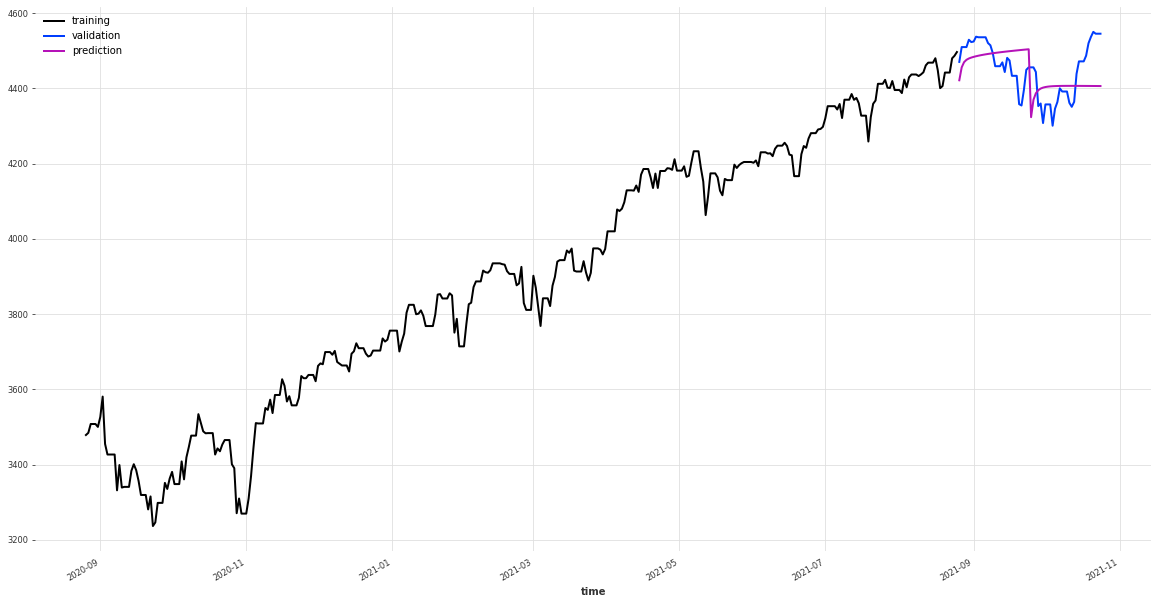

In [38]:
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

eval_model_RNN(darts.models.TFTModel(input_chunk_length=120,
                    output_chunk_length=30,
                    hidden_size=64,
                    lstm_layers=3,
                    num_attention_heads=4,
                    dropout=0.3,
                    batch_size=16,
                    n_epochs=10,
                    add_relative_index=True,
                    add_encoders=None,
                    optimizer_kwargs={'lr': 1e-3},                 
                    likelihood=QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
                    # loss_fn=MSELoss(),
                    random_state=42))

[2022-01-13 19:52:22,367] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4178 samples.
[2022-01-13 19:52:22,367] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4178 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 4178 samples.
[2022-01-13 19:52:22,406] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-13 19:52:22,406] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

model <darts.models.forecasting.transformer_model.TransformerModel object at 0x0000019785753040> obtains MAE: 89.391, MAPE: 2.015%, MSE: 12810.153, RMSE: 113.182


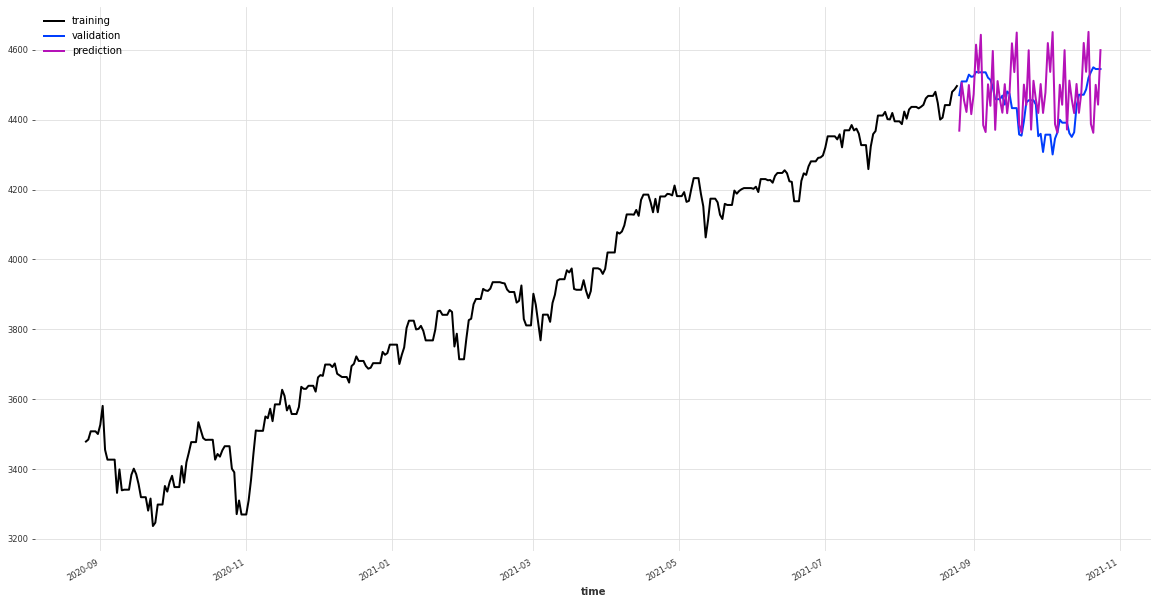

In [44]:
eval_model_RNN(darts.models.TransformerModel(
    input_chunk_length = 60,
    output_chunk_length = 15,
    batch_size = 32,
    n_epochs = 10,
    model_name = 'transformer',
    nr_epochs_val_period = 6,
    d_model = 64,
    nhead = 8,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    dim_feedforward = 2048,
    dropout = 0.1,
    activation = "relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True
))

model LGBModel(lags=[-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_past=None, lags_future=None) obtains MAE: 216.856, MAPE: 4.655%, MSE: 54999.968, RMSE: 234.521


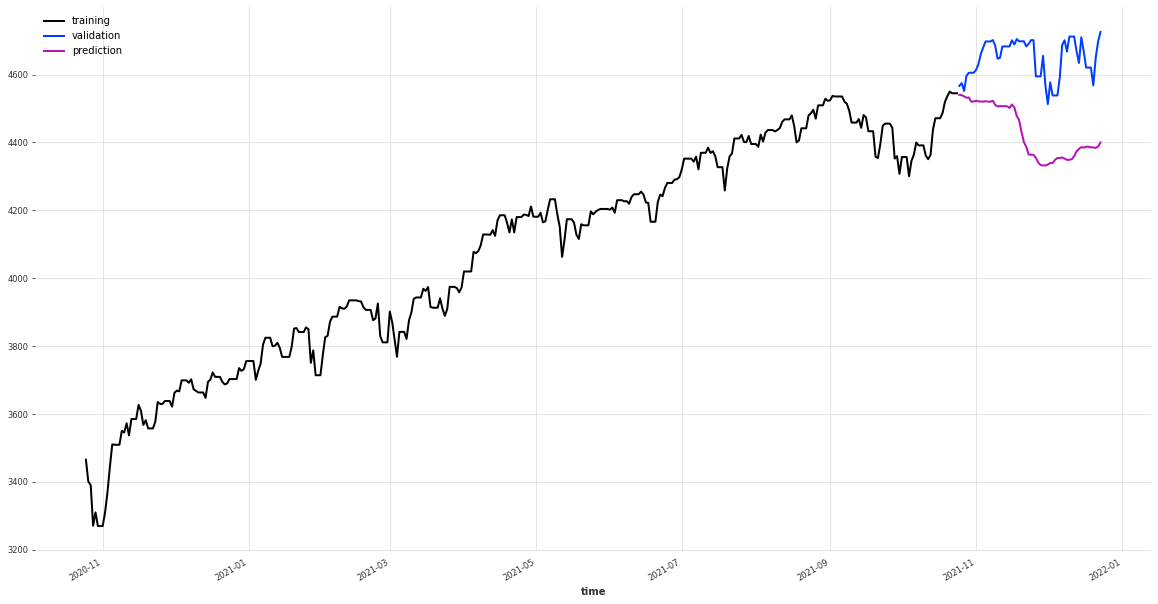

In [191]:
eval_model(darts.models.LightGBMModel(lags=60))

model LinearRegression(lags=[-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_past_covariates=None, lags_historical_covariates=None, lags_future_covariates=None obtains MAE: 61.146, MAPE: 1.310%, MSE: 4951.888, RMSE: 70.370


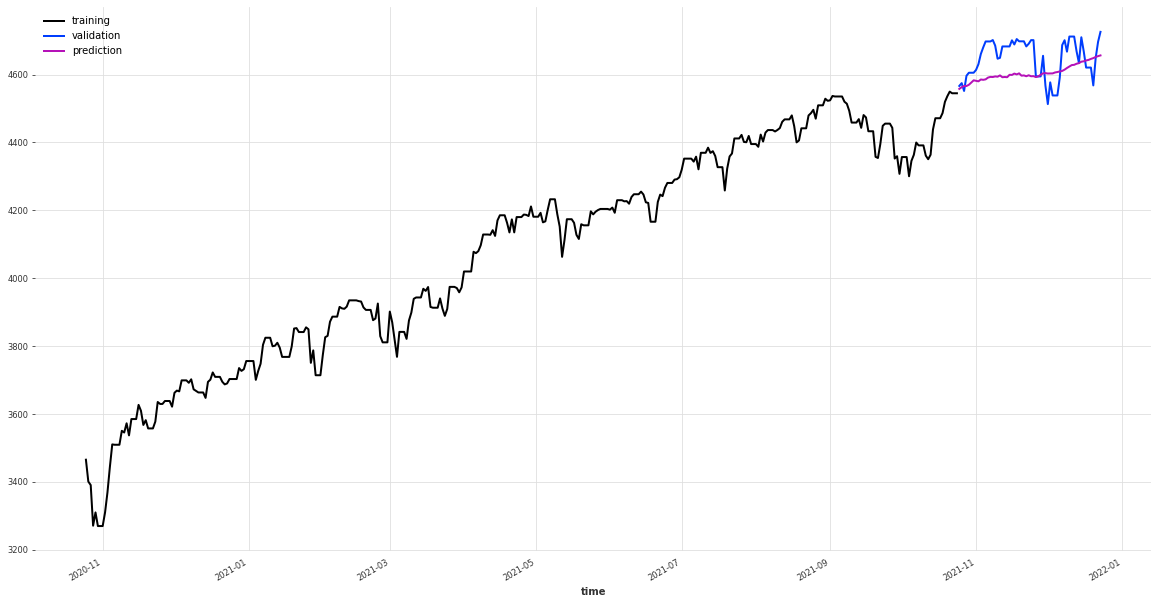

In [207]:
eval_model(darts.models.LinearRegressionModel(lags=60))

model Naive drift model obtains MAE: 85.218, MAPE: 1.823%, MSE: 9341.939, RMSE: 96.654


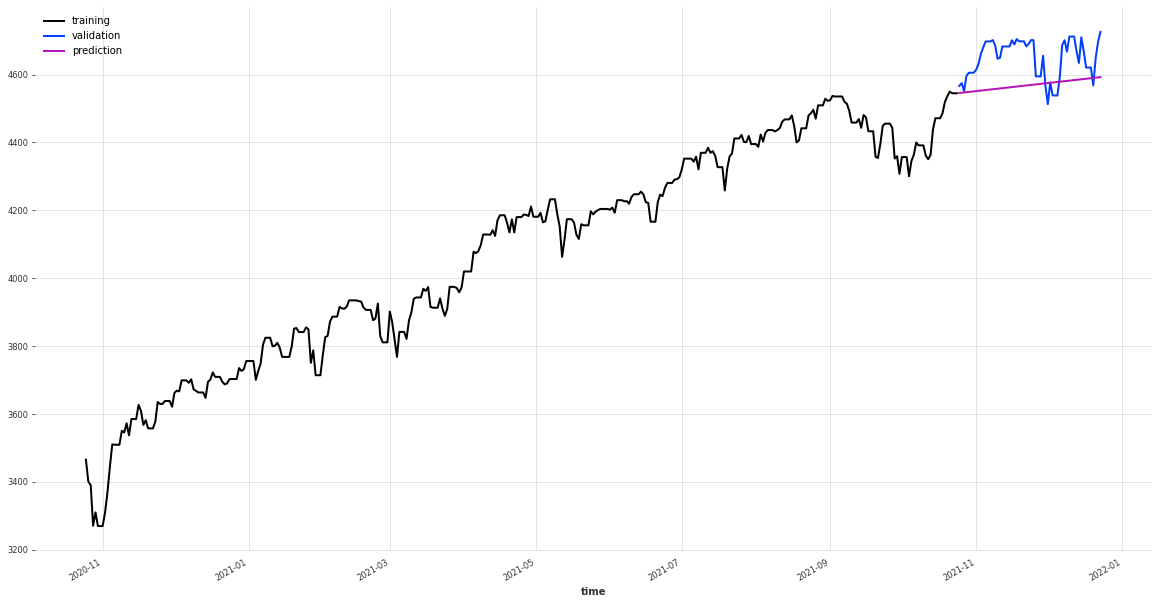

In [222]:
eval_model(darts.models.NaiveDrift())

model RandomForest(lags=[-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_past_covariates=None, lags_historical_covariates=None, lags_future_covariates=None, n_estimators=20, max_depth=15 obtains MAE: 120.559, MAPE: 2.579%, MSE: 17896.530, RMSE: 133.778


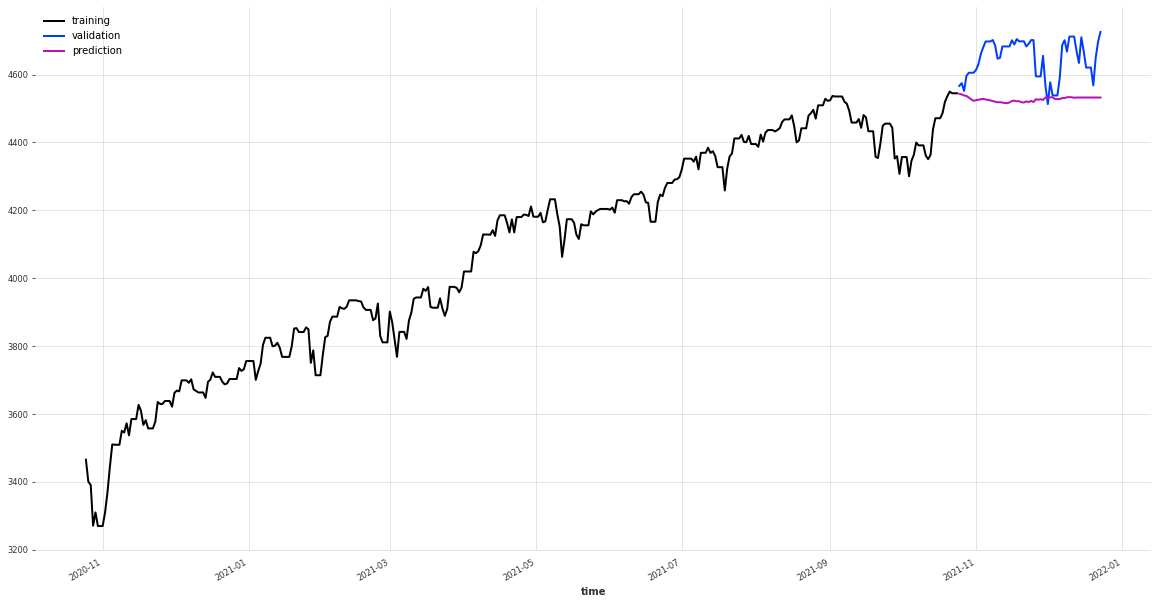

In [218]:
eval_model(darts.models.RandomForest(lags=60, n_estimators=20, max_depth=15))

model Naive mean predictor model obtains MAE: 2259.741, MAPE: 50.765%, MSE: 5111330.044, RMSE: 2260.825


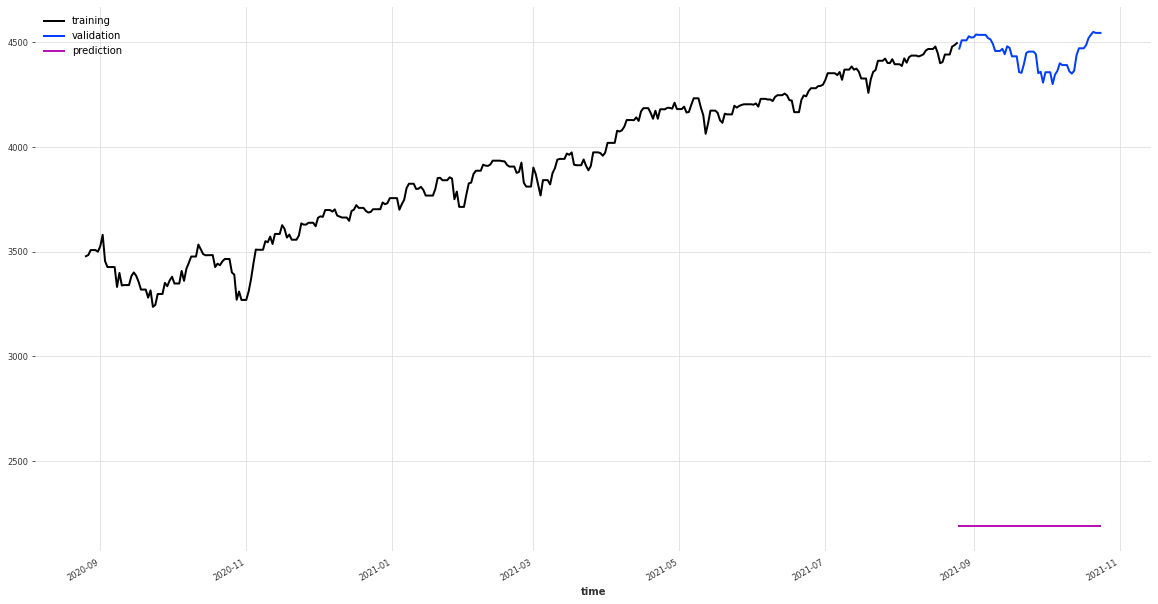

In [49]:
eval_model_RNN(darts.models.NaiveMean())

model Naive seasonal model, with K=1 obtains MAE: 104.137, MAPE: 2.227%, MSE: 13640.783, RMSE: 116.794


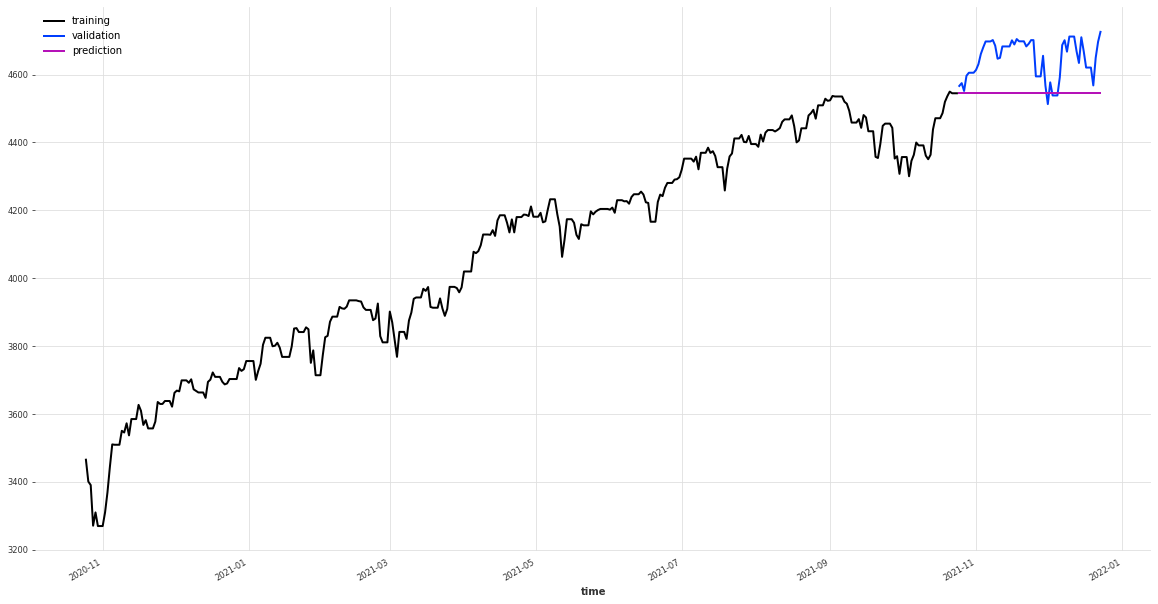

In [229]:
eval_model(darts.models.NaiveSeasonal())